In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.globals import PYMC3
from src.io import cache_io, model_config
from src.loggers import logger, set_console_handler_level
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.models import configuration, speclet_model
from src.models.speclet_five import SpecletFive
from src.models.speclet_four import SpecletFour
from src.models.speclet_seven import SpecletSeven
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor, make_pal

In [3]:
notebook_tic = time()

set_console_handler_level(logging.WARNING)
warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
HDI_PROB = PYMC3.HDI_PROB

In [4]:
def build_and_load_caches(name: str) -> speclet_model.SpecletModel:
    """Instantiate a SpecletModel, build its model, and load its cached fitting results."""
    sp = configuration.get_config_and_instantiate_model(
        model_config.get_model_config(),
        name=name,
        root_cache_dir=cache_io.default_cache_dir(),
    )
    sp.build_model()
    if sp.cache_manager.mcmc_cache_exists() and sp.cache_manager.advi_cache_exists():
        _ = sp.load_advi_cache()
        _ = sp.load_mcmc_cache()
    else:
        print("Either the MCMC or ADVI cache does not exist for '{sp.name}'.")
    return sp

In [5]:
sp4_centered_cn: SpecletFour = build_and_load_caches("sp4-centered-copynum")
sp4_noncentered_cn: SpecletFour = build_and_load_caches("sp4-noncentered-copynum")

[07/11/21 10:56:03] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1626015363.8927429-886725;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1626015363.905886-778463;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

[07/11/21 10:56:27] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1626015387.430657-446906;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1626015387.446743-416260;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

Looking at the trace plots of the hypoerpriors for SpecletFour models with centered and non-centered parameterizations, there were a lot of divergences.

sp4-centered-copynum


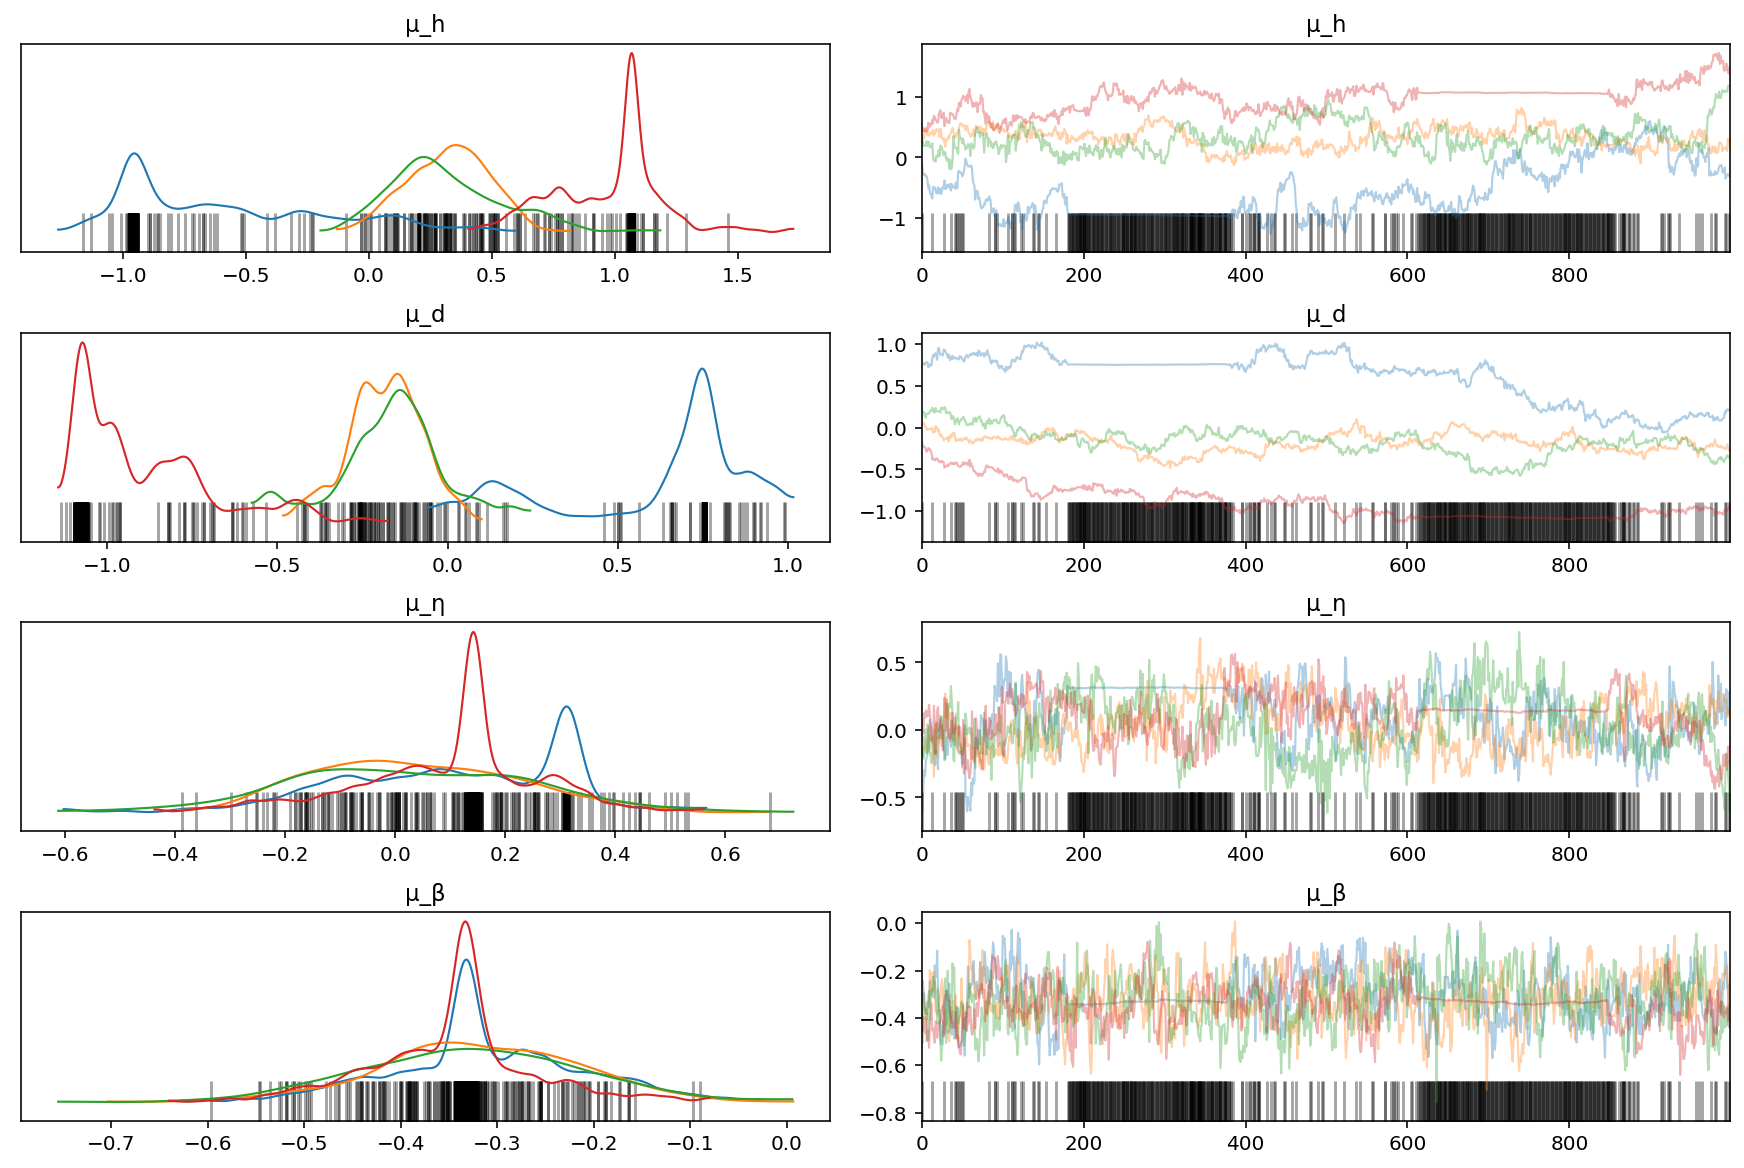

sp4-noncentered-copynum


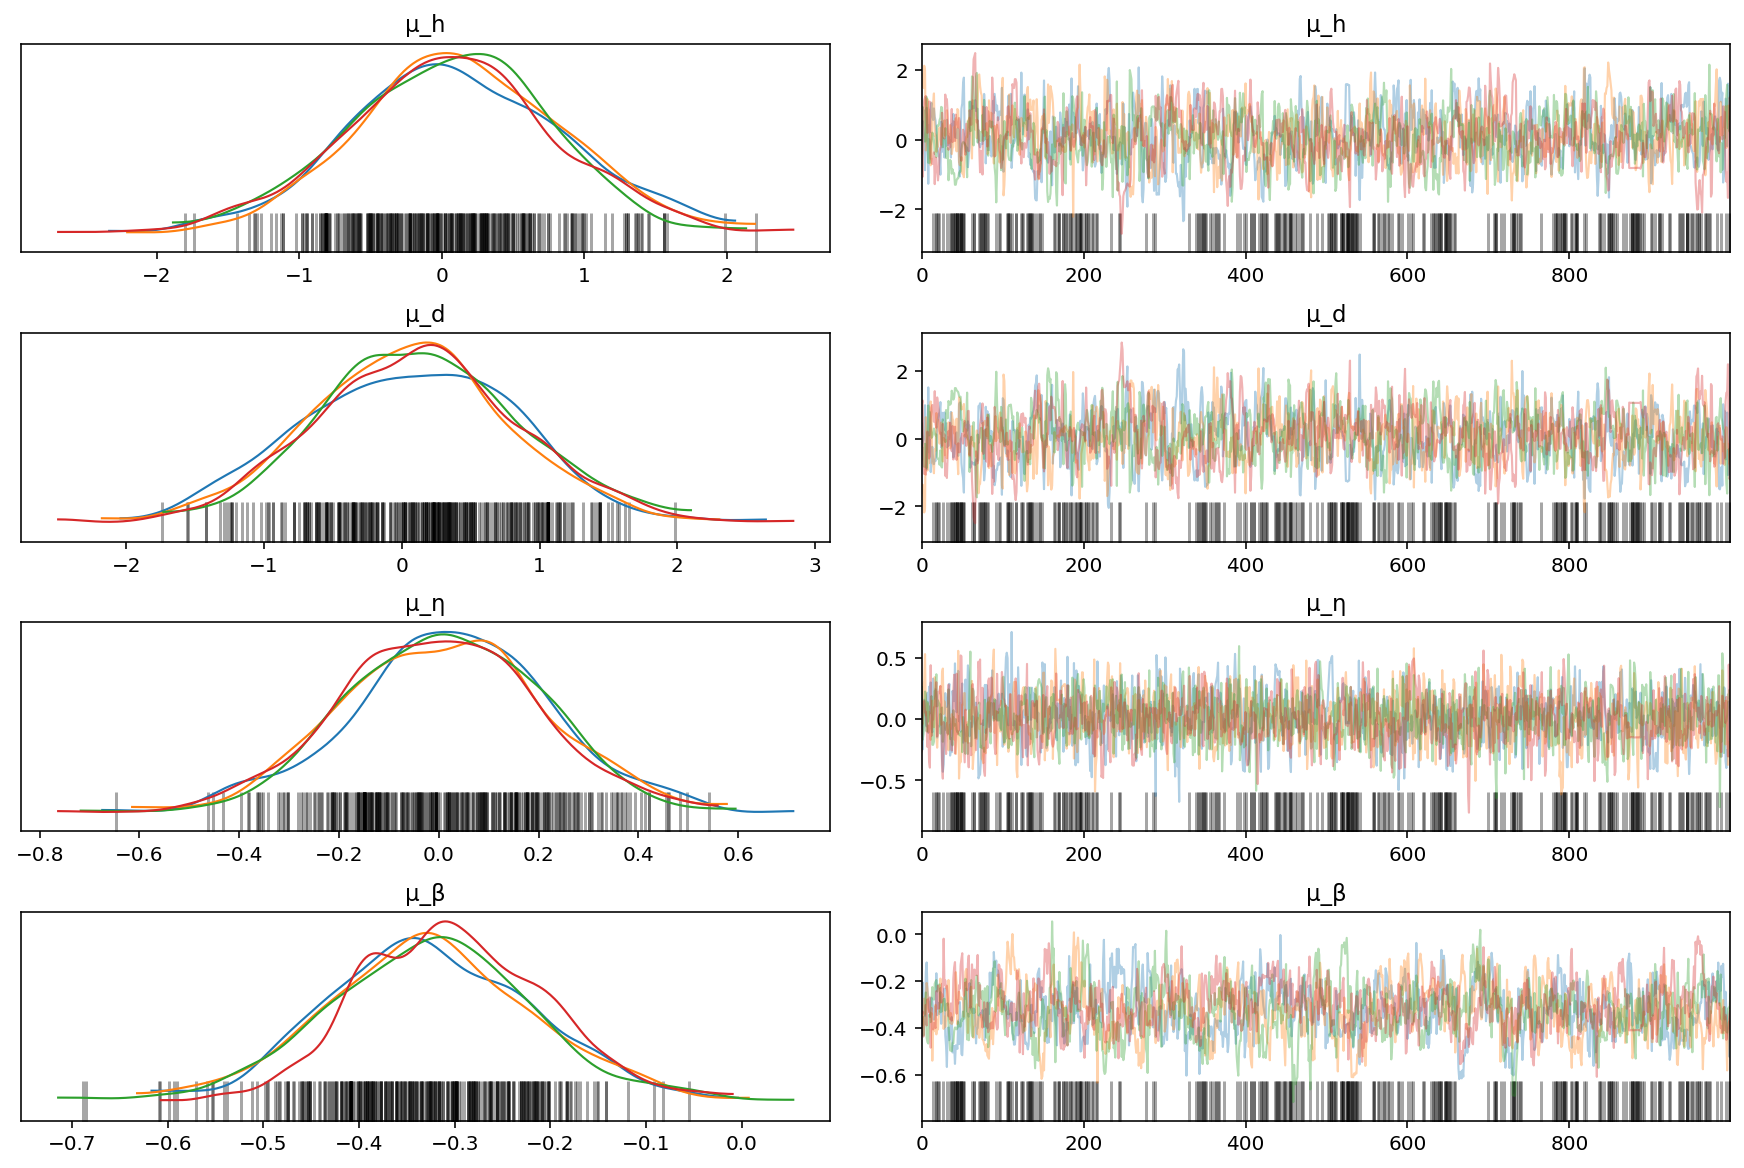

In [6]:
for sp in (sp4_centered_cn, sp4_noncentered_cn):
    print(sp.name)
    az.plot_trace(
        sp.mcmc_results, var_names=["μ_h", "μ_d", "μ_η", "μ_β"], compact=False
    )
    plt.show()

In [7]:
sp5_centered: SpecletFour = build_and_load_caches("sp5-default")
sp5_noncentered: SpecletFour = build_and_load_caches("sp5-noncentered")

[07/11/21 10:56:36] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1626015396.123179-347343;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1626015396.1451478-949899;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

[07/11/21 10:56:39] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1626015399.9420018-317530;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1626015399.953481-328200;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

As with SpecletFour, the SpecletFive models had a lot of divergences during the MCMC fitting process.
In my opinion, this is likely caused by either the high correlation between equivalent variables or by the restrictive priors that are there for the same reason.
This suggests that moving away from CERES-like parameters will be necessary to have a model that fits.

sp5-default


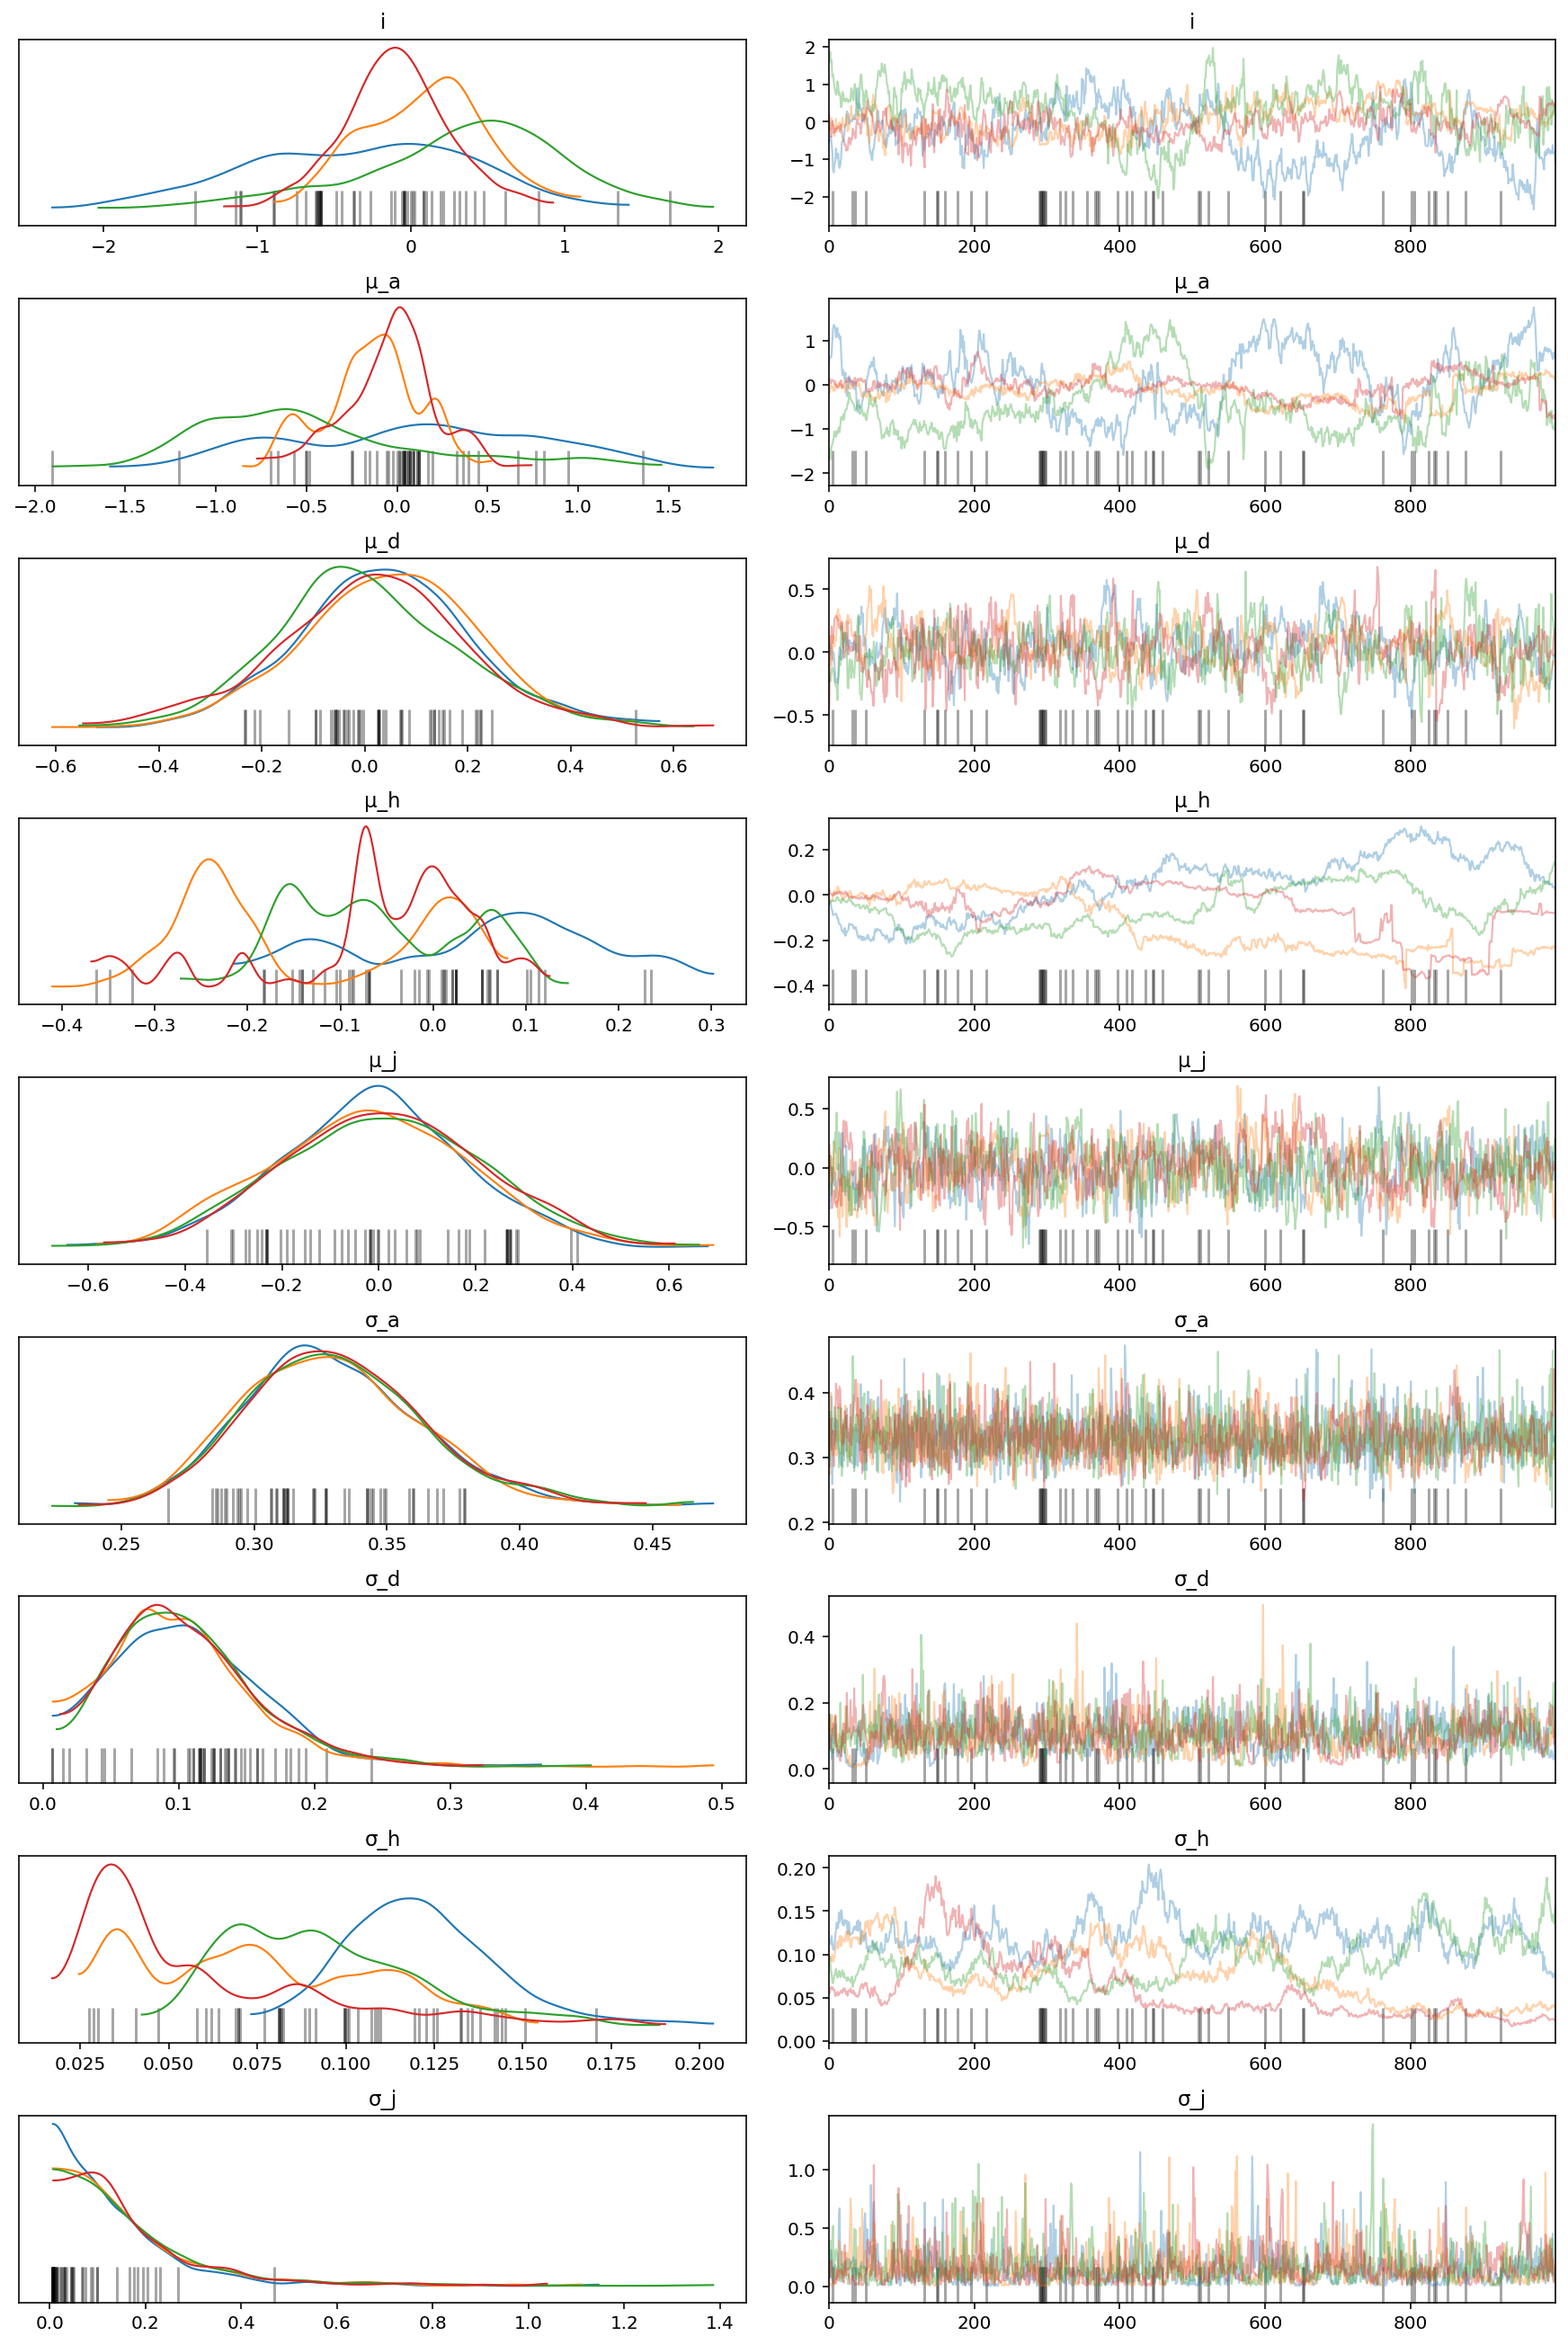

sp5-noncentered


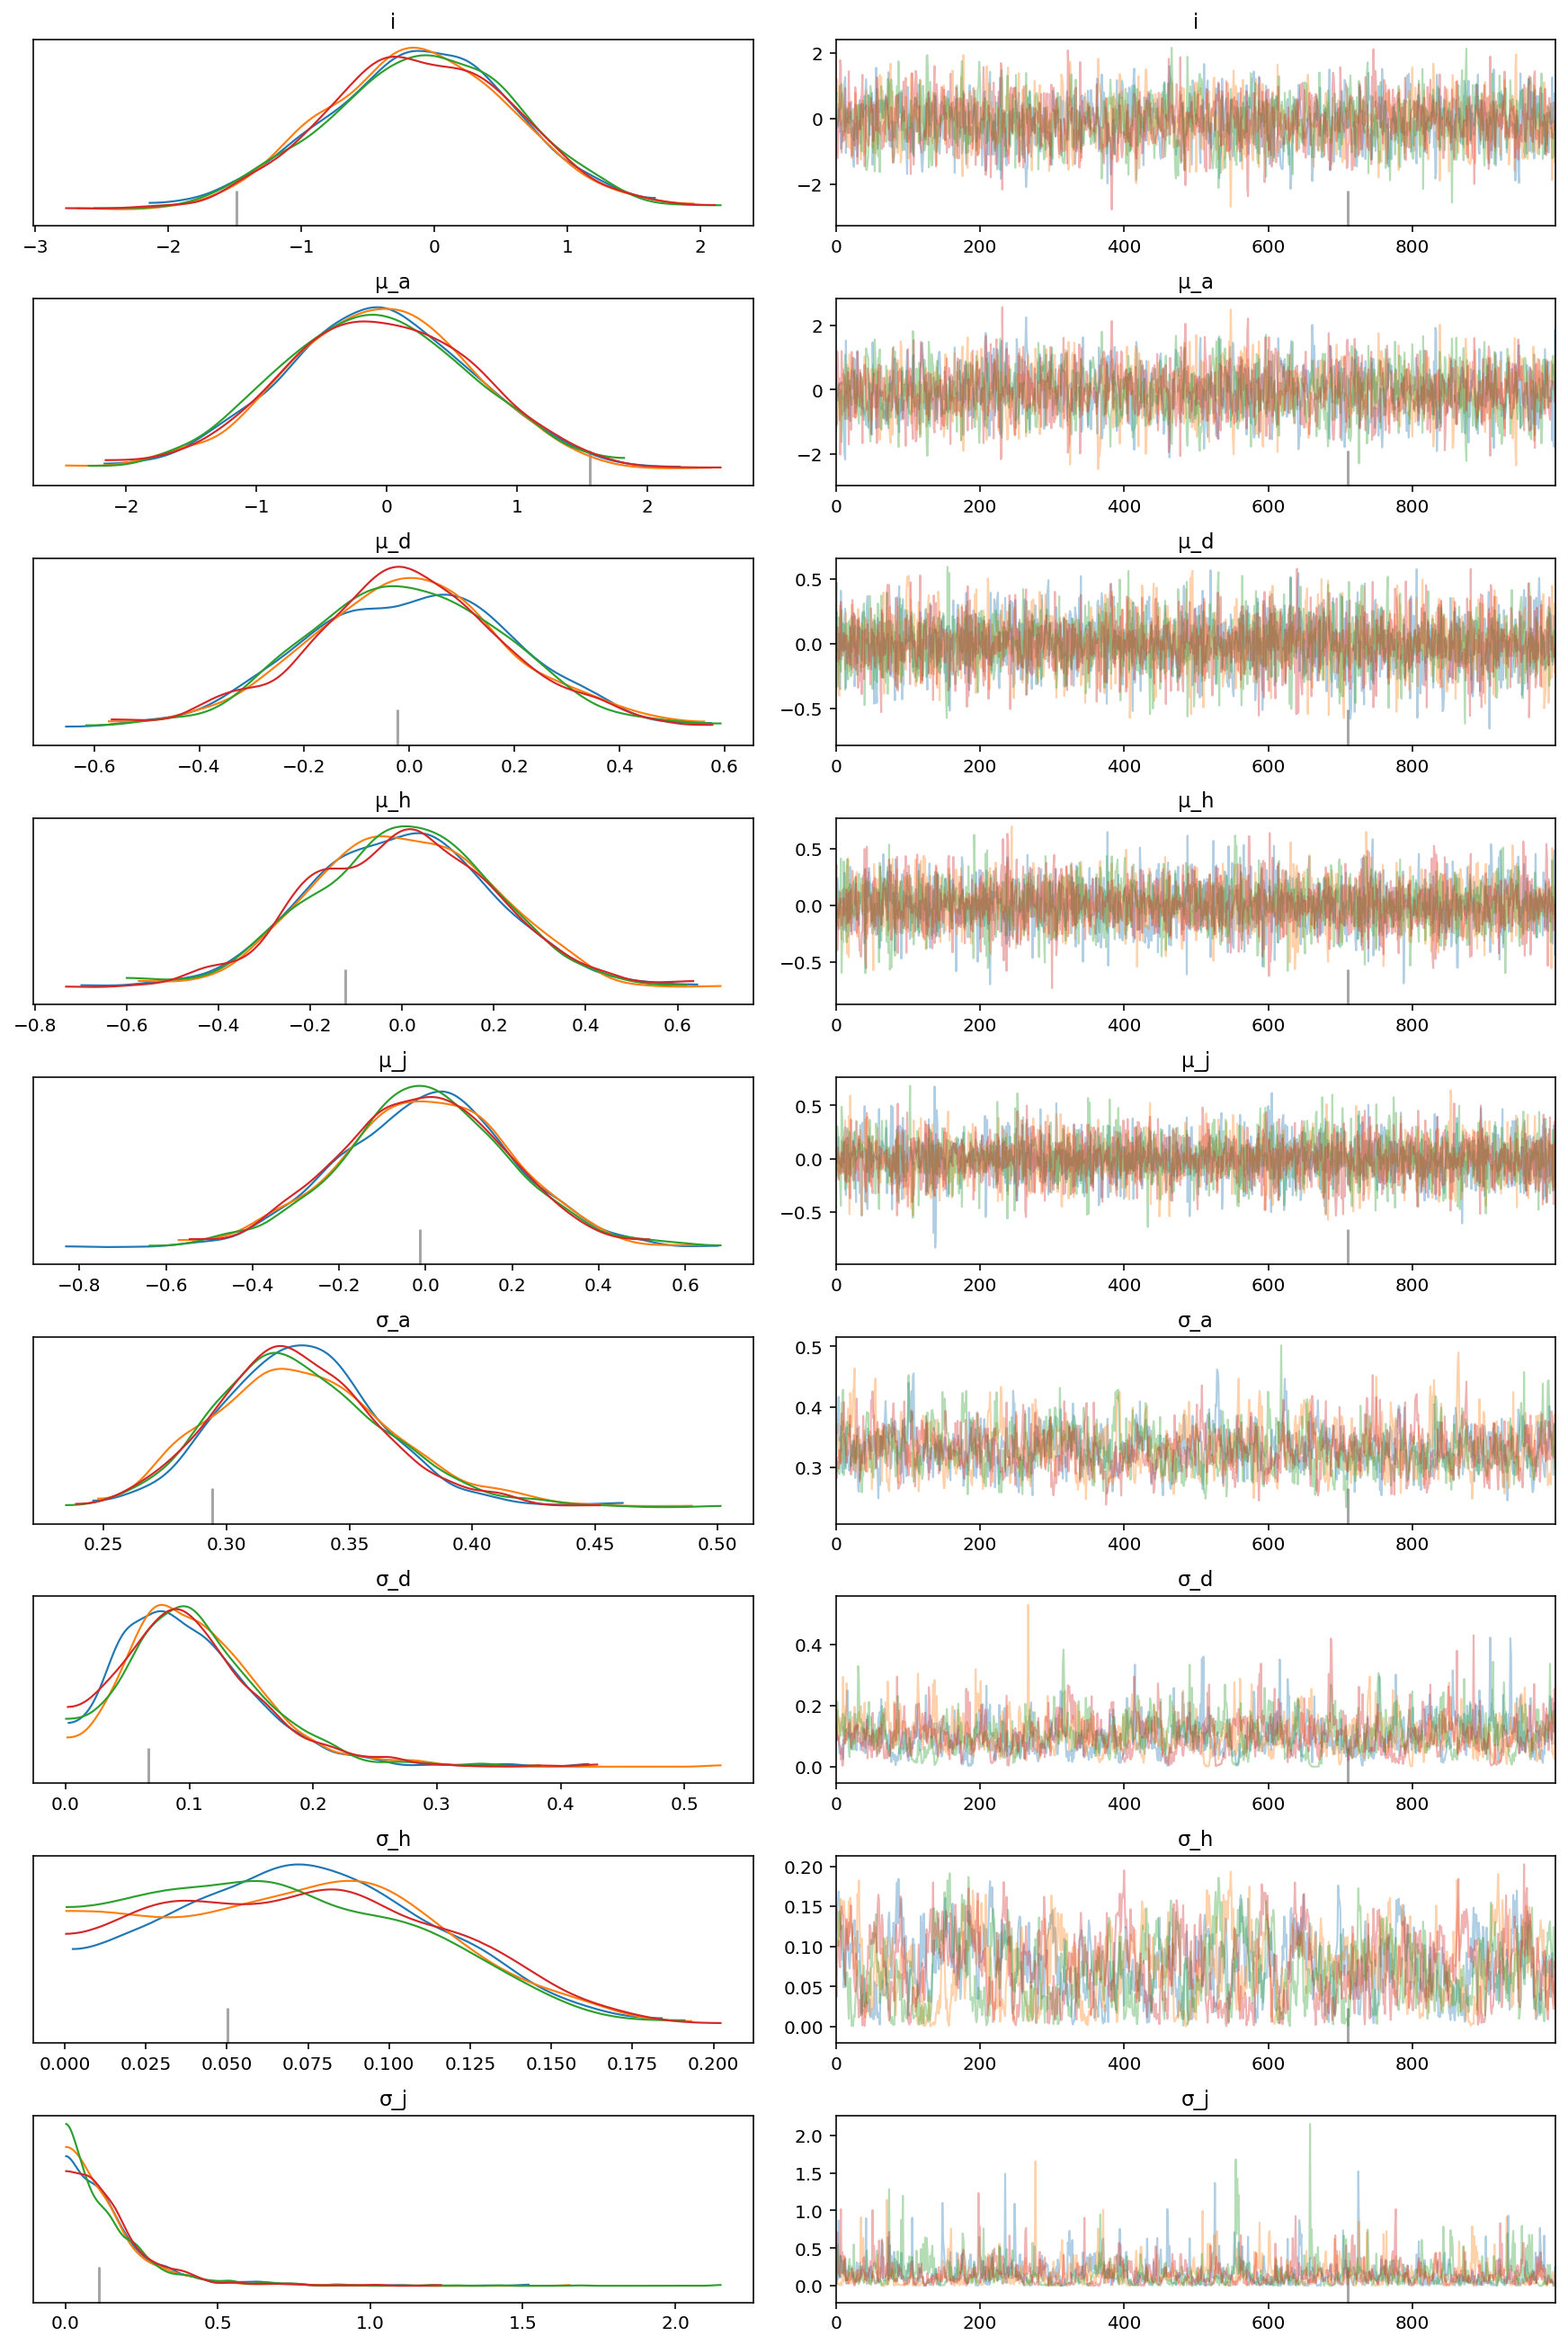

In [8]:
hyper_priors = [f"μ_{v}" for v in ("a", "d", "h", "j")]
hyper_priors += [f"σ_{v}" for v in ("a", "d", "h", "j")]
for sp in (sp5_centered, sp5_noncentered):
    print(sp.name)
    az.plot_trace(sp.mcmc_results, var_names=["i"] + hyper_priors, compact=False)
    plt.show()

In [9]:
sgrnas = sp5_noncentered.data_manager.get_data()["sgrna"].cat.categories.tolist()
genes = sp5_noncentered.data_manager.get_data()["hugo_symbol"].cat.categories.tolist()
cell_lines = sp5_noncentered.data_manager.get_data()[
    "depmap_id"
].cat.categories.tolist()
lineages = sp5_noncentered.data_manager.get_data()["lineage"].cat.categories.tolist()

Some of the posteriors for $a$, the consistent gene effect, have a 89% credible interval (CI) that is beyond a ROPE of $[-0.1, 0.1]$.
Some of the genes are notable, including *STK11* and *GATA6*, but others are new to me, such as *PLCD4* and *FUT7*.

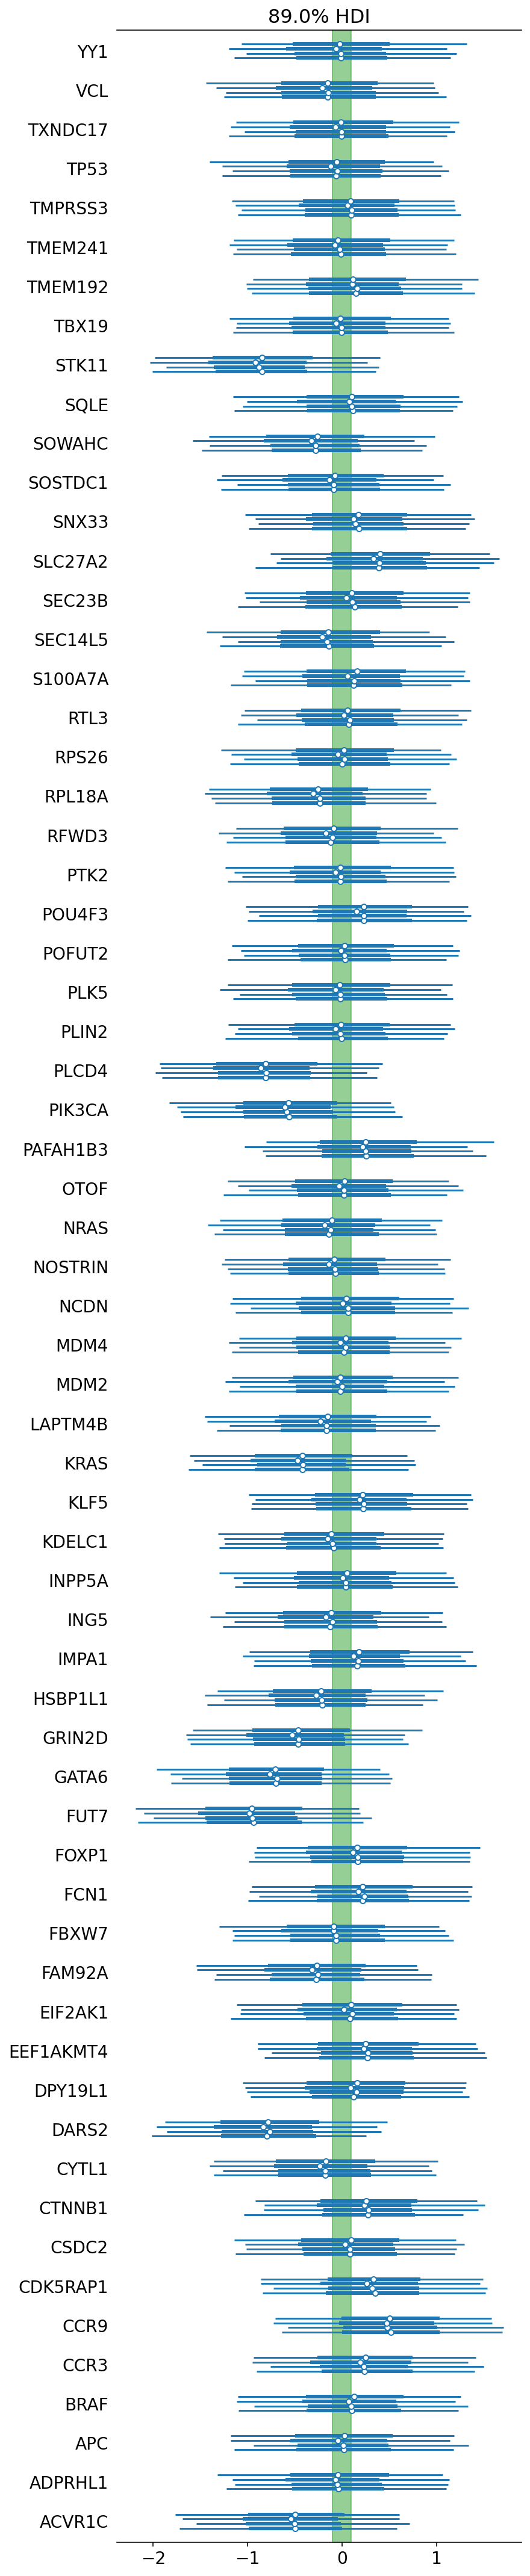

In [10]:
axes = az.plot_forest(
    sp5_noncentered.mcmc_results,
    var_names=["a"],
    rope=(-0.1, 0.1),
    hdi_prob=PYMC3.HDI_PROB,
)
axes[0].set_yticklabels(genes)
plt.show()

In [11]:
sp5_posterior_a = az.summary(
    sp5_noncentered.mcmc_results, var_names="a", hdi_prob=PYMC3.HDI_PROB
)
sp5_posterior_a["hugo_symbol"] = genes

The following plot shows the posteriors (mean and 89% CI) for $a$ overalyed on the real LFC data points for each gene.
Keep in mind that there are other parameters in the model to account for different modes of variability, so the posteriors of $a$ should not align perfectly with the data.

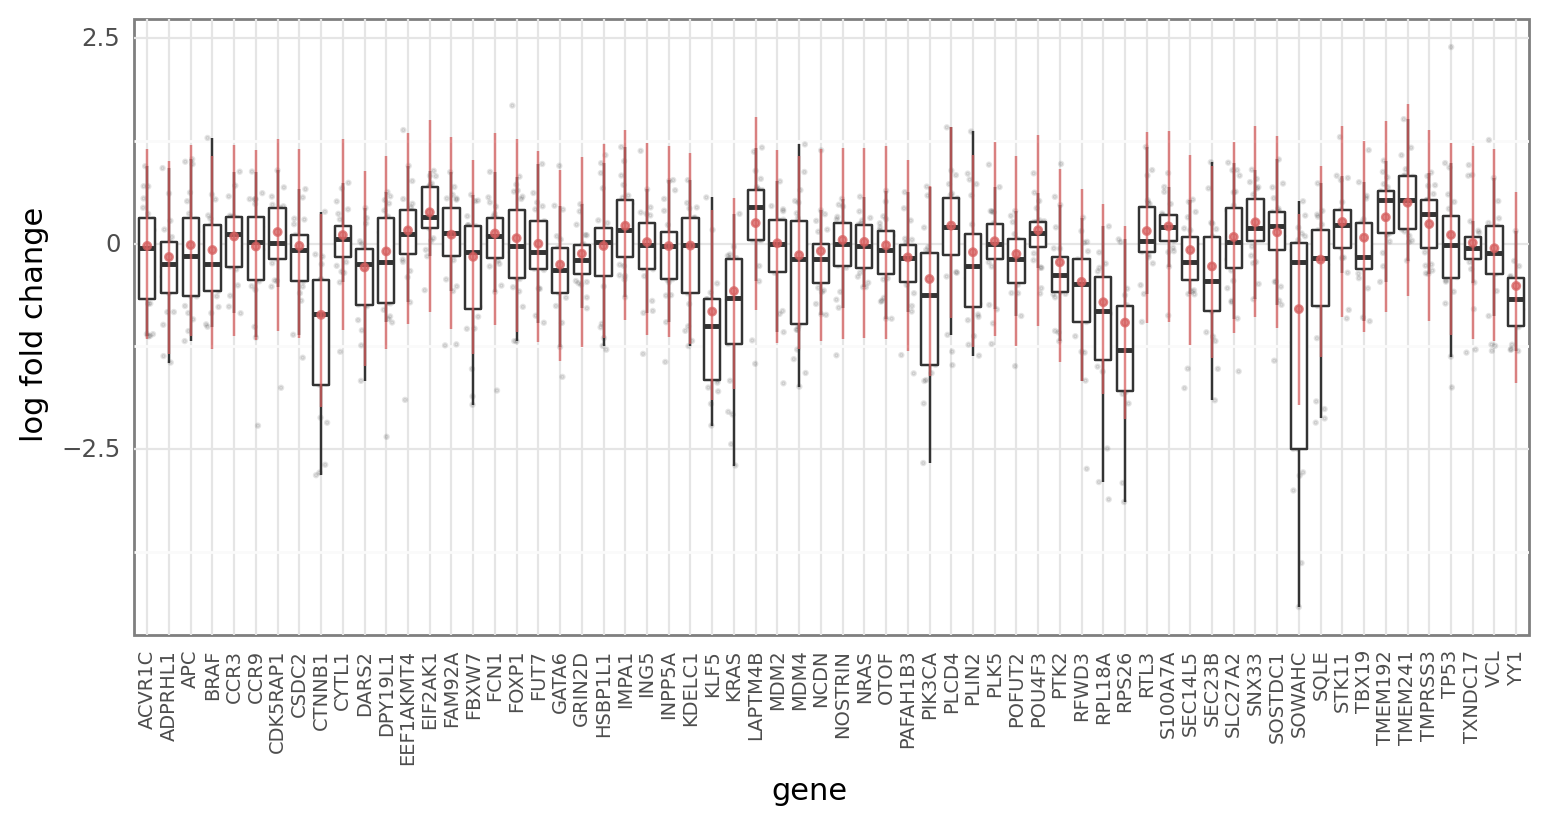

<ggplot: (369305579)>

In [12]:
screen_data = sp5_noncentered.data_manager.get_data()

(
    gg.ggplot(screen_data, gg.aes(x="hugo_symbol", y="lfc"))
    + gg.geom_jitter(alpha=0.1, size=0.3, height=0, width=0.3)
    + gg.geom_boxplot(outlier_alpha=0)
    + gg.geom_point(
        gg.aes(y="mean"),
        data=sp5_posterior_a,
        color=SeabornColor.RED,
        size=1,
        alpha=0.75,
    )
    + gg.geom_linerange(
        gg.aes(y="mean", ymin="hdi_5.5%", ymax="hdi_94.5%"),
        data=sp5_posterior_a,
        color=SeabornColor.RED,
        alpha=0.75,
    )
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=7), figure_size=(9, 4))
    + gg.labs(x="gene", y="log fold change")
)

As expected, the posterior predictive distribution for SpecletFive is quite different from the real distribution of LFC values.
SpecletFive is meant to be a simple alternative for SpecletSix and purposefully omits some import covariates and has a simpler hierarchical structure.

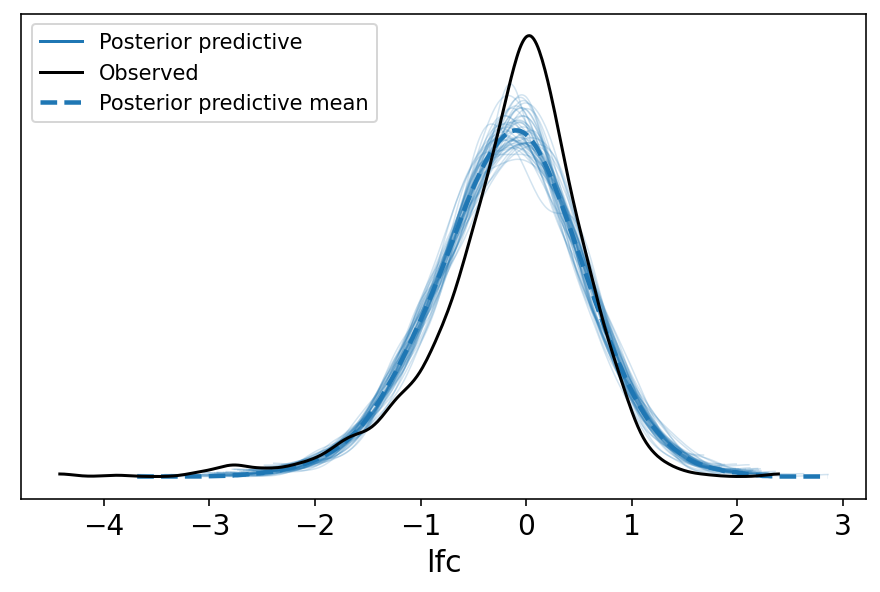

In [13]:
az.plot_ppc(sp5_noncentered.mcmc_results, num_pp_samples=50);

### SpecletSeven

SpecletSeven is a fairly "deep" model with only a single covariate $a$ in the main level.
$a$ is a 2-dimensional varying intercept, varying for sgRNA and cell line.
The mean of that distribution is also 2D, varying by gene and cell line.
Again, the mean of that distribution is varying by gene and lineage.
Thus, this model produces a gene effect estimate for each cell line and lineage, sharing information hierarchically.

In addition to varying hyperparameters on the means of prior distributions, some of the standard deviations of those priors having varying effects.
For instance, the standard deviation of the prior for the gene/cell line parameter varies by cell line, allowing for different variability of gene effects per cell line.
Each sgRNA also has its own standard deviation hyperprior.

*Note: for this example data set, there is only one lineage: colorectal carcinoma (CRC).*

In [14]:
sp7: SpecletSeven = build_and_load_caches("sp7-default")

[07/11/21 10:57:25] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1626015445.44527-159006;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1626015445.457218-961577;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

There are still some divergences, but this may be amerliorated by increasing `target_accept` when fitting the model or loosening lower-level priors and tightening top-level priors.
Interestingly, there are different levels of autocorrelation for each chain.

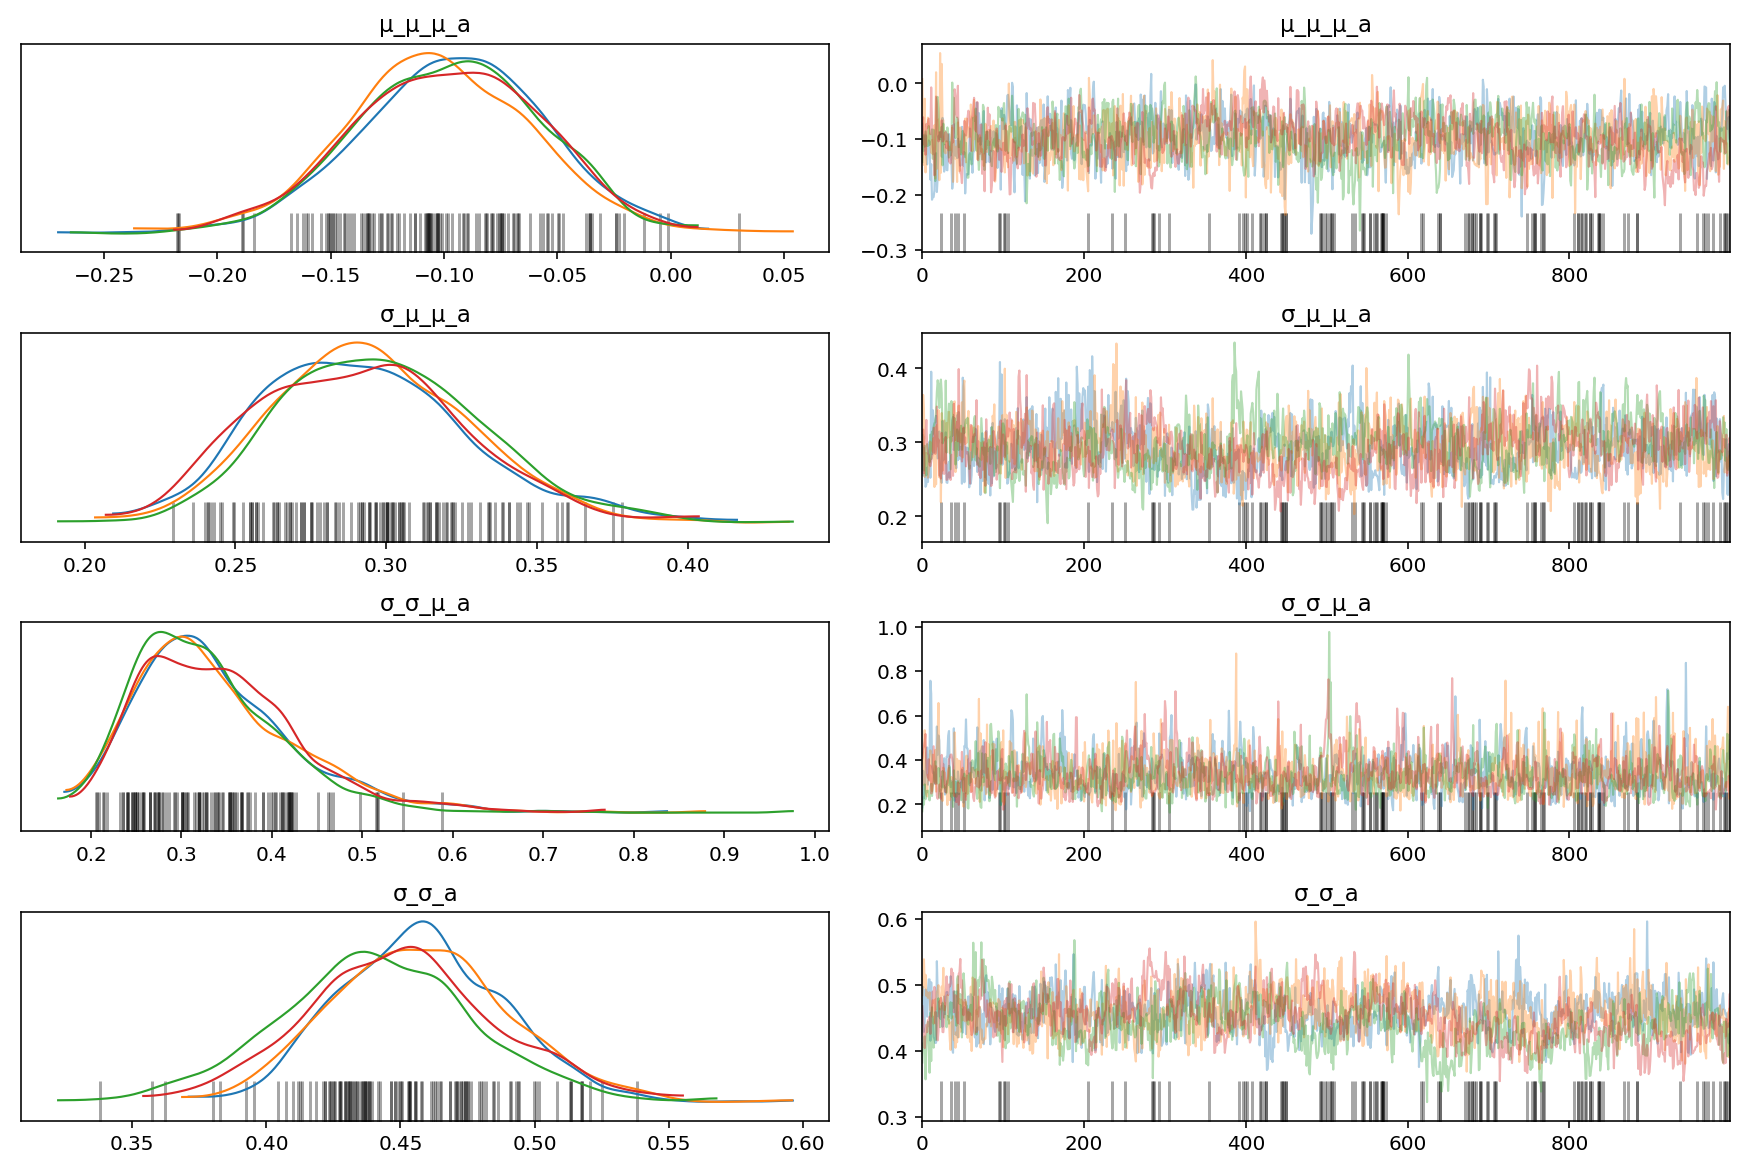

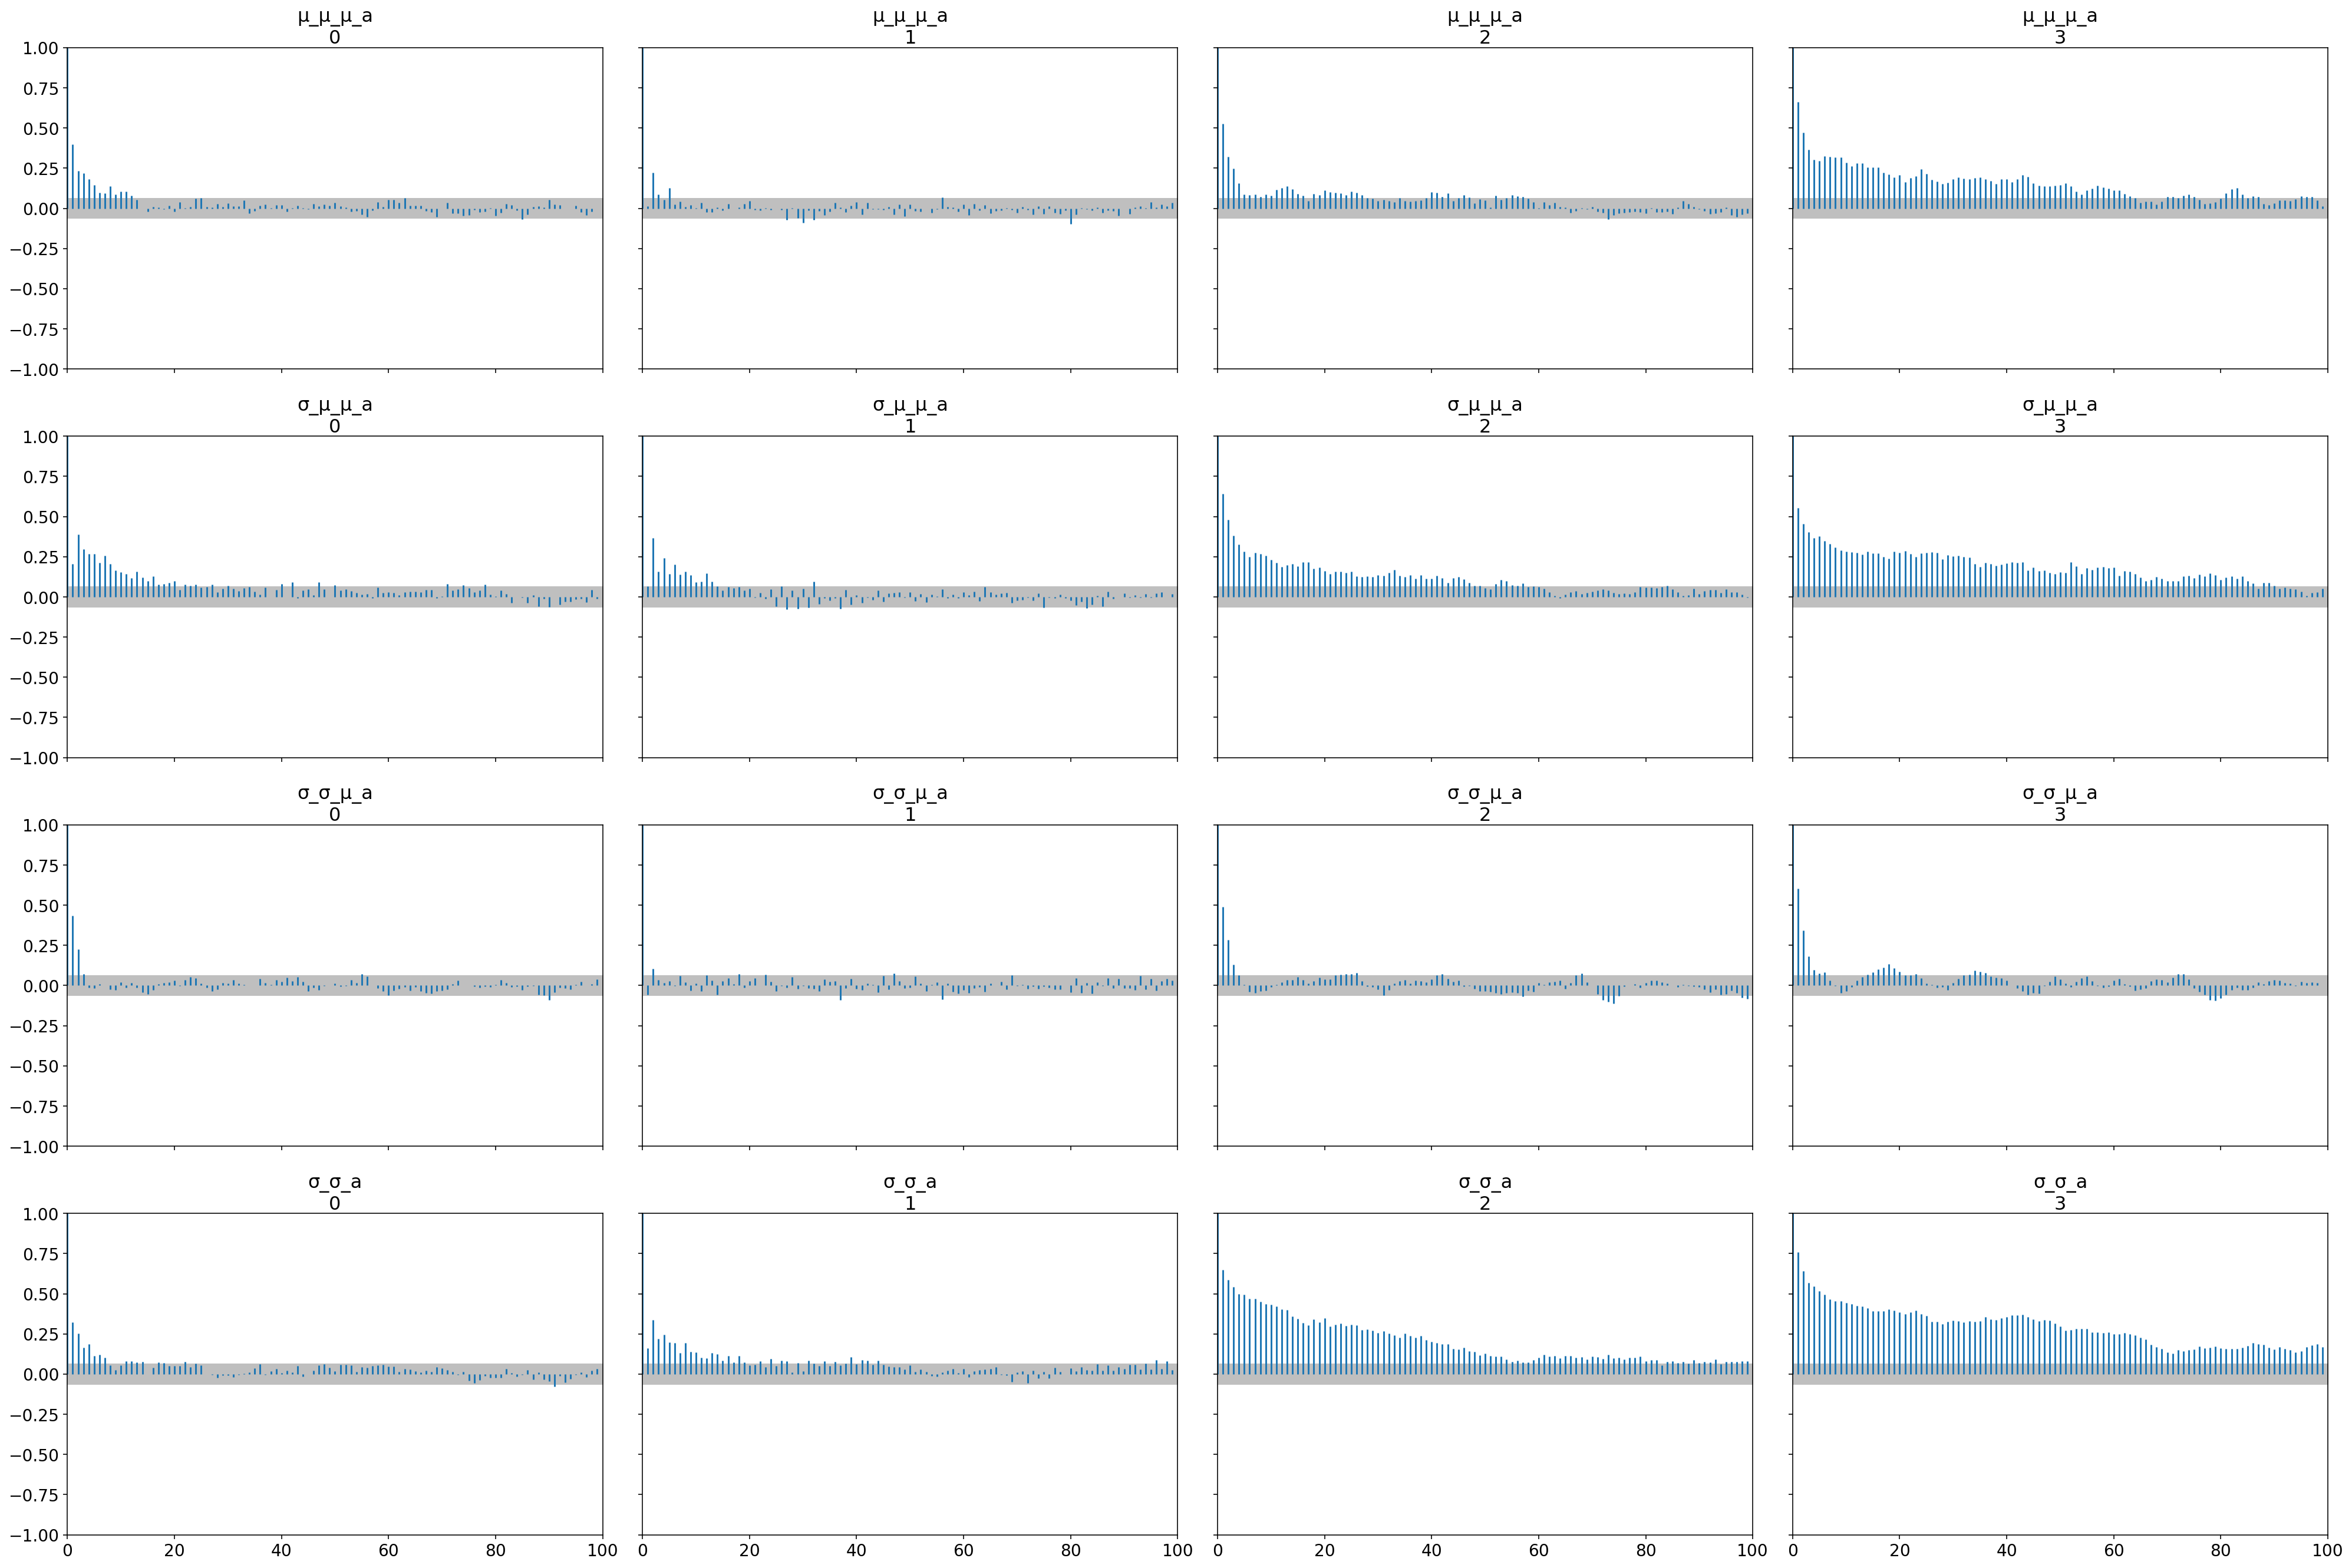

In [15]:
sp7_top_params = ["μ_μ_μ_a", "σ_μ_μ_a", "σ_σ_μ_a", "σ_σ_a"]
az.plot_trace(sp7.mcmc_results, var_names=sp7_top_params, compact=False)
az.plot_autocorr(sp7.mcmc_results, var_names=sp7_top_params);

The top level hyperpriors do not show substantial correlation.

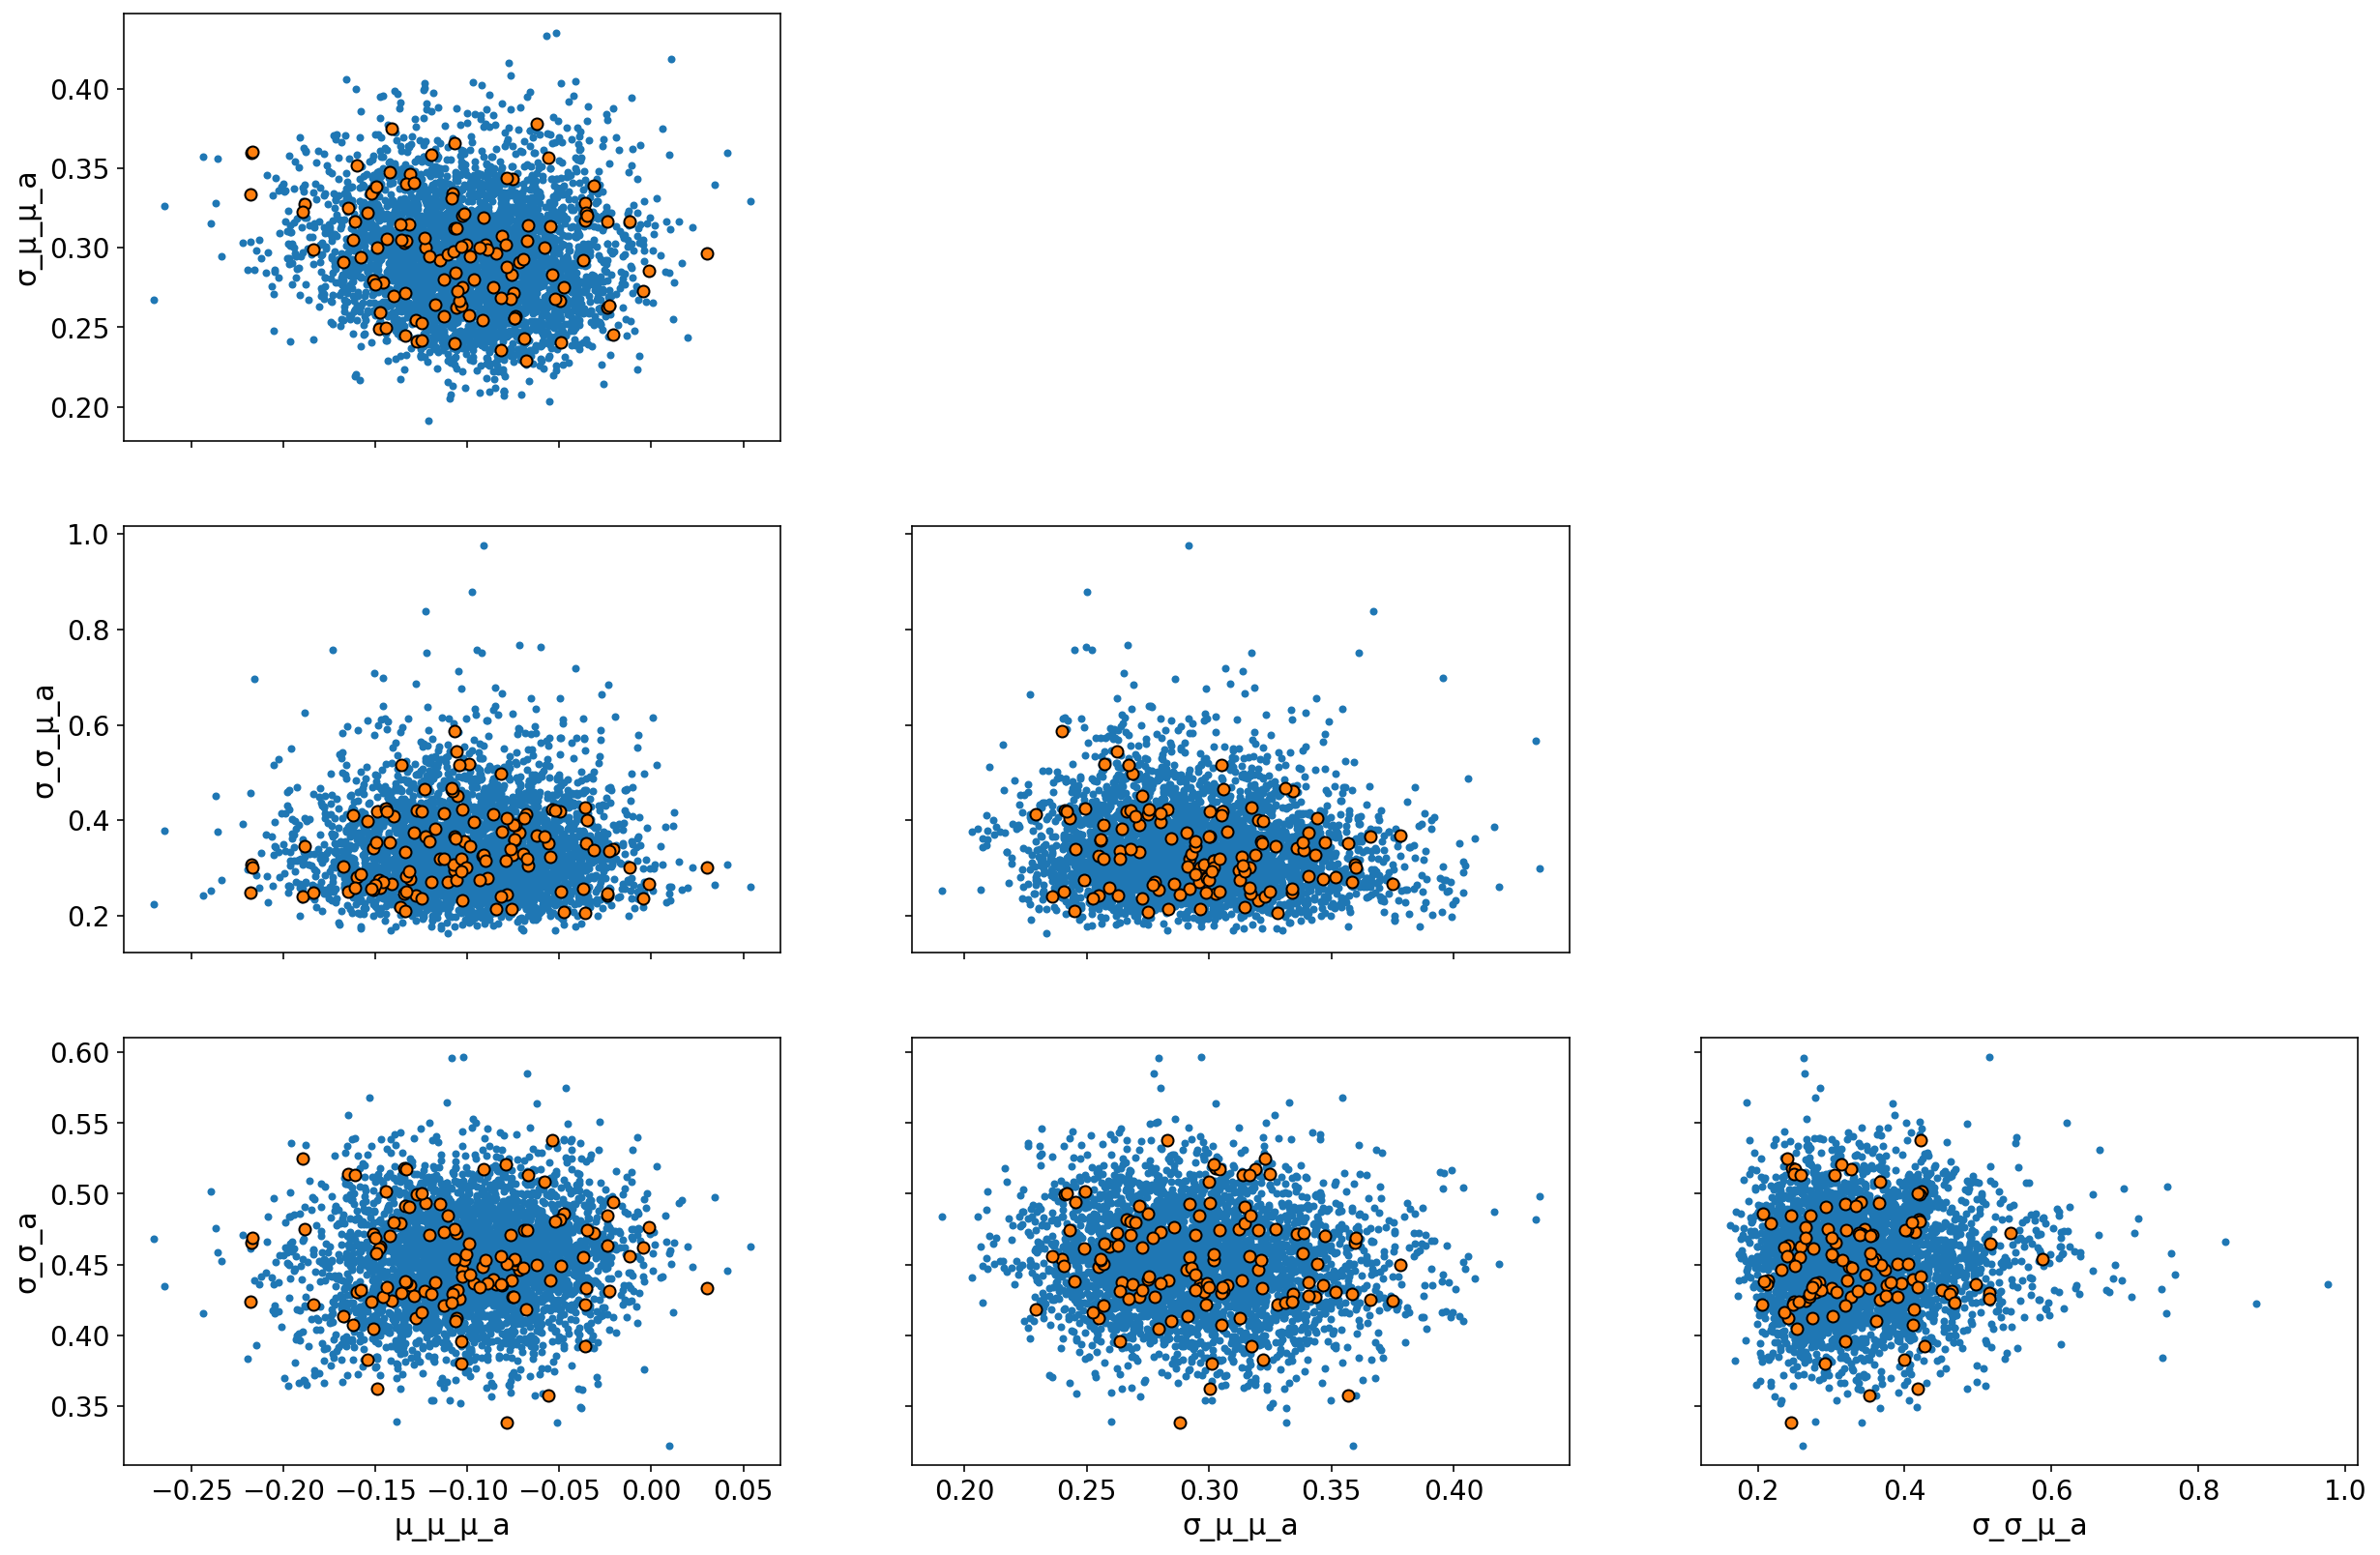

In [16]:
az.plot_pair(sp7.mcmc_results, var_names=sp7_top_params, divergences=True);

While still not perfect, the posterior predictive distributions are much closer to the real (observed) LFC distributions compared to SpecletFive (which had more parameters).

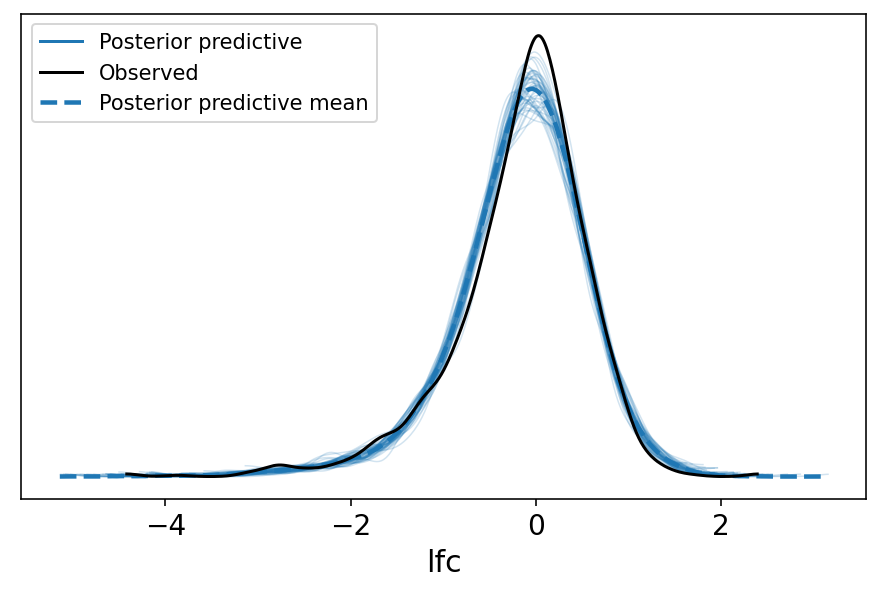

In [17]:
az.plot_ppc(sp7.mcmc_results, num_pp_samples=50);

In [18]:
sp7.data_manager.get_data()[["lineage", "depmap_id"]].drop_duplicates().reset_index(
    drop=True
)

lineage   depmap_id
0  colorectal  ACH-000007
1  colorectal  ACH-000249
2  colorectal  ACH-000552
3  colorectal  ACH-000722
4  colorectal  ACH-000969
5  colorectal  ACH-000970
6  colorectal  ACH-000997
7  colorectal  ACH-001345
8  colorectal  ACH-002233
9  colorectal  ACH-000470

In [19]:
sp7_posterior_mu_a = (
    az.summary(sp7.mcmc_results, var_names=["μ_a"], hdi_prob=PYMC3.HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "parameter"})
    .pipe(
        pmanal.extract_matrix_variable_indices,
        col="parameter",
        idx1=np.array(genes),
        idx2=np.array(cell_lines),
        idx1name="hugo_symbol",
        idx2name="depmap_id",
    )
)

The parameter $\mu_a$ is a varying intercept for gene and cell line.
Therefore, the posterior values represent the effect of knocking out the target gene in the cell line.
Note that becuase of the hierarhcical structure of the model, information is shared across all of the cell lines of the same lineage.

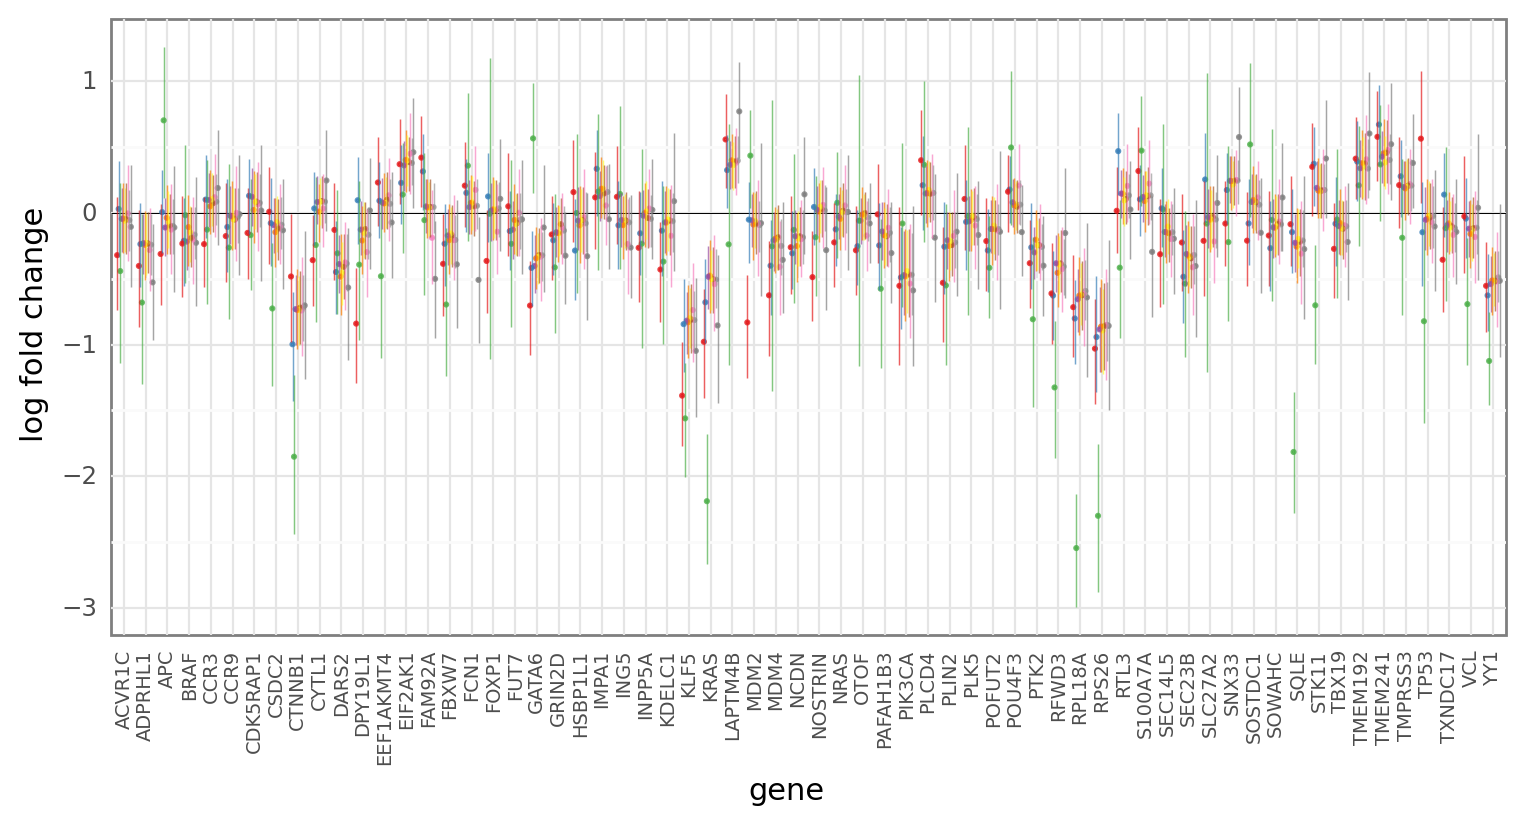

<ggplot: (371711479)>

In [20]:
pos = gg.position_dodge(width=0.7)

(
    gg.ggplot(sp7_posterior_mu_a, gg.aes(x="hugo_symbol", y="mean"))
    + gg.geom_hline(yintercept=0, color="black", size=0.2)
    + gg.geom_point(gg.aes(color="depmap_id"), size=0.25, position=pos, alpha=0.8)
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", color="depmap_id"),
        position=pos,
        size=0.3,
        alpha=0.7,
    )
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=7),
        figure_size=(9, 4),
        legend_position="none",
    )
    + gg.labs(x="gene", y="log fold change")
)

In [21]:
sp7_posterior_mu_mu_a = (
    az.summary(sp7.mcmc_results, var_names=["μ_μ_a"], hdi_prob=PYMC3.HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "parameter"})
    .pipe(
        pmanal.extract_matrix_variable_indices,
        col="parameter",
        idx1=np.array(genes),
        idx2=np.array(lineages),
        idx1name="hugo_symbol",
        idx2name="lineage",
    )
)

The plot below shows the cell-line specific effects of knocking out a selection of 6 genes that show some variability.
Each subplot represnets a different target gene with the cell lines arranged along the x-axis.
For each cell line, the triangular points represent data points from individual sgRNA (indiciated by color).
The point and error bar for each cell line is the estimated *gene effect* (effect of knocking out the gene in the cell line) showing the mean and 89% credible interval (CI).
For each gene, there is also a global lineage gene effect (only CRC at the moment) represented by the dashed horizontal line with a 89 CI indicated by the shaded region.
This region represents the estiamted effect of knocking out the gene in a CRC cell line.

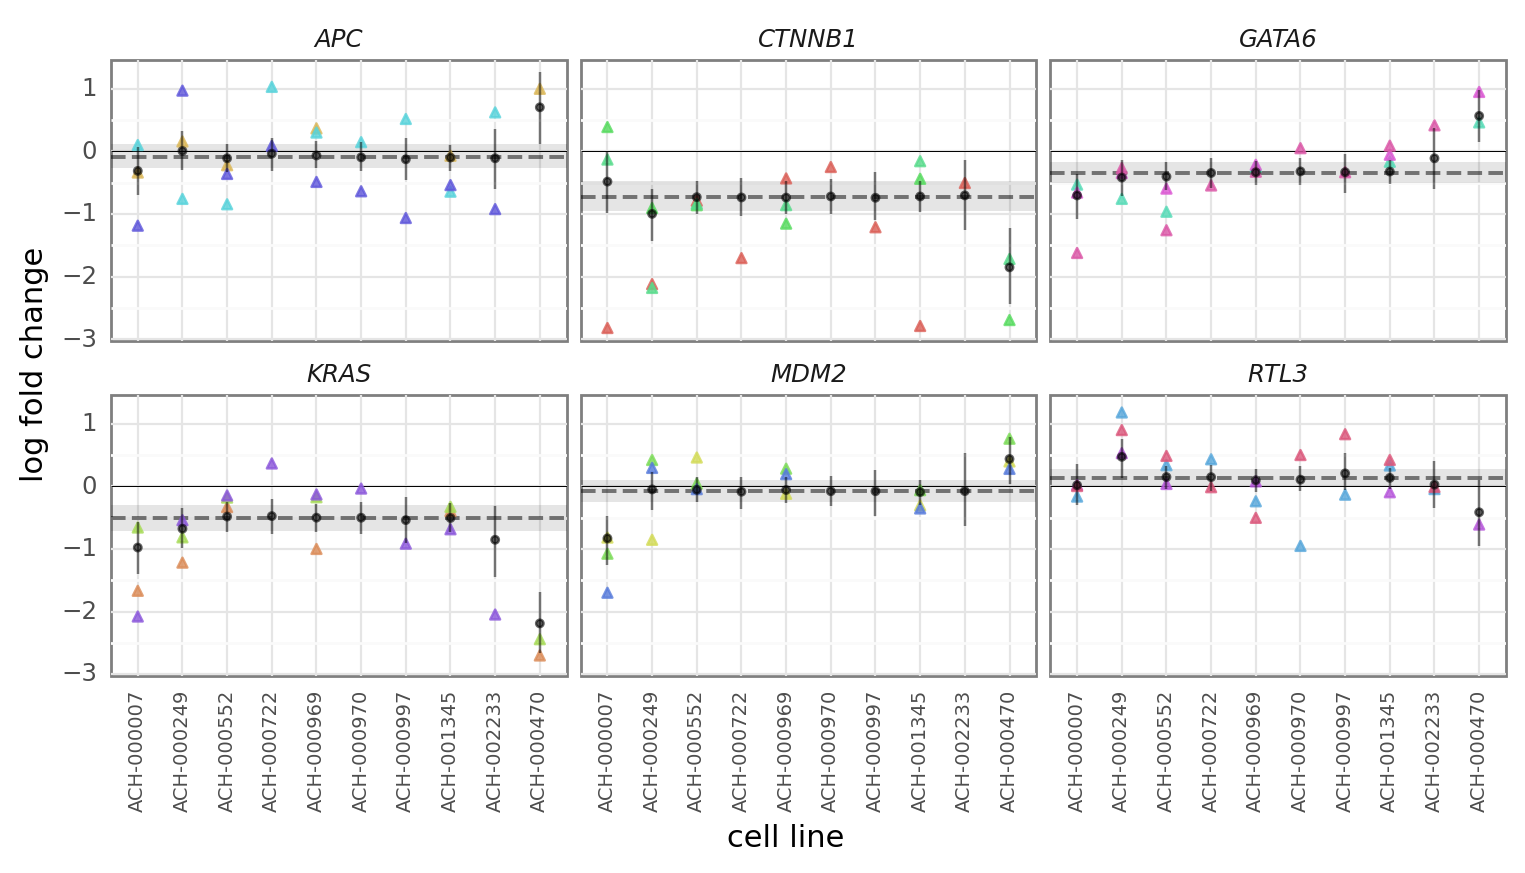

<ggplot: (372152601)>

In [22]:
subset_genes = ["APC", "KRAS", "CTNNB1", "GATA6", "RTL3", "MDM2"]

screen_data_subset = screen_data[screen_data.hugo_symbol.isin(subset_genes)].assign(
    sgrna=lambda d: d.sgrna.to_list()
)
sp7_posterior_mu_a_subset = sp7_posterior_mu_a[
    sp7_posterior_mu_a.hugo_symbol.isin(subset_genes)
]
sp7_posterior_mu_mu_a_subset = sp7_posterior_mu_mu_a[
    sp7_posterior_mu_mu_a.hugo_symbol.isin(subset_genes)
]


(
    gg.ggplot(screen_data_subset, gg.aes(x="depmap_id", y="lfc"))
    + gg.facet_wrap("~ hugo_symbol", nrow=2)
    + gg.geom_hline(yintercept=0, color="black", size=0.2)
    + gg.geom_rect(
        gg.aes(xmin=-np.inf, xmax=np.inf, ymin="hdi_5.5%", ymax="hdi_94.5%"),
        data=sp7_posterior_mu_mu_a_subset,
        size=1,
        fill="black",
        alpha=0.1,
        inherit_aes=False,
    )
    + gg.geom_hline(
        gg.aes(yintercept="mean"),
        data=sp7_posterior_mu_mu_a_subset,
        alpha=0.5,
        size=0.8,
        linetype="--",
    )
    + gg.geom_point(gg.aes(color="sgrna"), shape="^", alpha=0.8)
    + gg.geom_linerange(
        gg.aes(y="mean", ymin="hdi_5.5%", ymax="hdi_94.5%"),
        data=sp7_posterior_mu_a_subset,
        alpha=0.5,
    )
    + gg.geom_point(
        gg.aes(y="mean"),
        data=sp7_posterior_mu_a_subset,
        alpha=0.6,
        size=1,
    )
    + gg.theme(
        strip_text_x=gg.element_text(face="italic"),
        legend_position="none",
        axis_text_x=gg.element_text(size=7, angle=90),
        figure_size=(9, 4),
    )
    + gg.labs(x="cell line", y="log fold change")
)

The following table shows the cell lines with mutations in the genes shown above.

In [23]:
screen_data_subset[["depmap_id", "hugo_symbol", "is_mutated"]].query(
    "is_mutated"
).drop_duplicates().sort_values(["hugo_symbol", "depmap_id"]).set_index("hugo_symbol")

depmap_id  is_mutated
hugo_symbol                        
APC          ACH-000249        True
APC          ACH-000552        True
APC          ACH-000969        True
APC          ACH-000970        True
APC          ACH-000997        True
APC          ACH-001345        True
APC          ACH-002233        True
APC          ACH-000470        True
GATA6        ACH-000997        True
GATA6        ACH-001345        True
KRAS         ACH-000007        True
KRAS         ACH-000249        True
KRAS         ACH-000997        True
KRAS         ACH-001345        True
KRAS         ACH-000470        True
MDM2         ACH-001345        True

The parameter $\sigma_{\mu_a}$ is a varying effect parameter on the standard deviation for $\mu_a$.
It varies per cell line, thus representing the varibility of gene effects per cell line.
We can inspect this parameter to see which cell lines demonstrated more vairable responses.

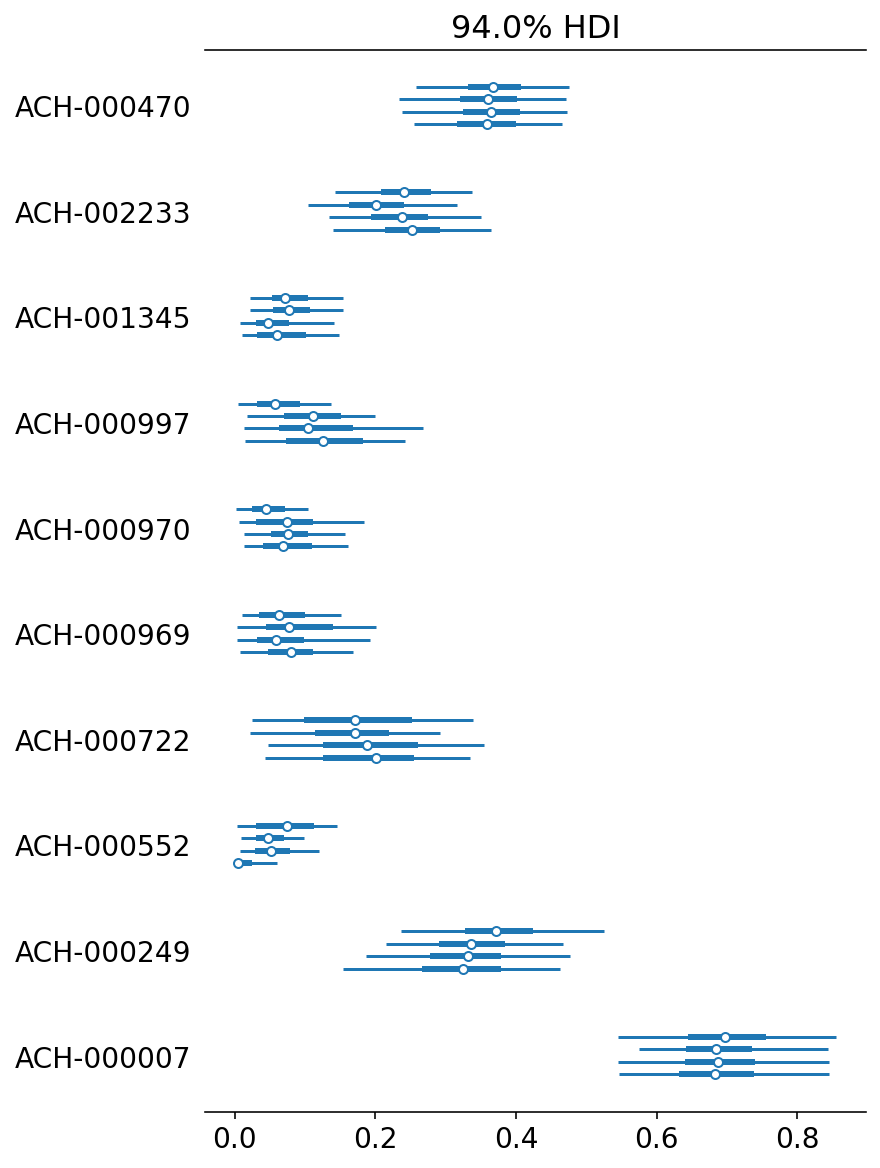

In [24]:
axes = az.plot_forest(sp7.mcmc_results, var_names=["σ_μ_a"])
axes[0].set_yticklabels(cell_lines)
plt.show()

The plot below shows the distrivbution of LFC values for each cell line (different color).
The coloration of the cell lines is in increasing order of variability as estimated by the model.

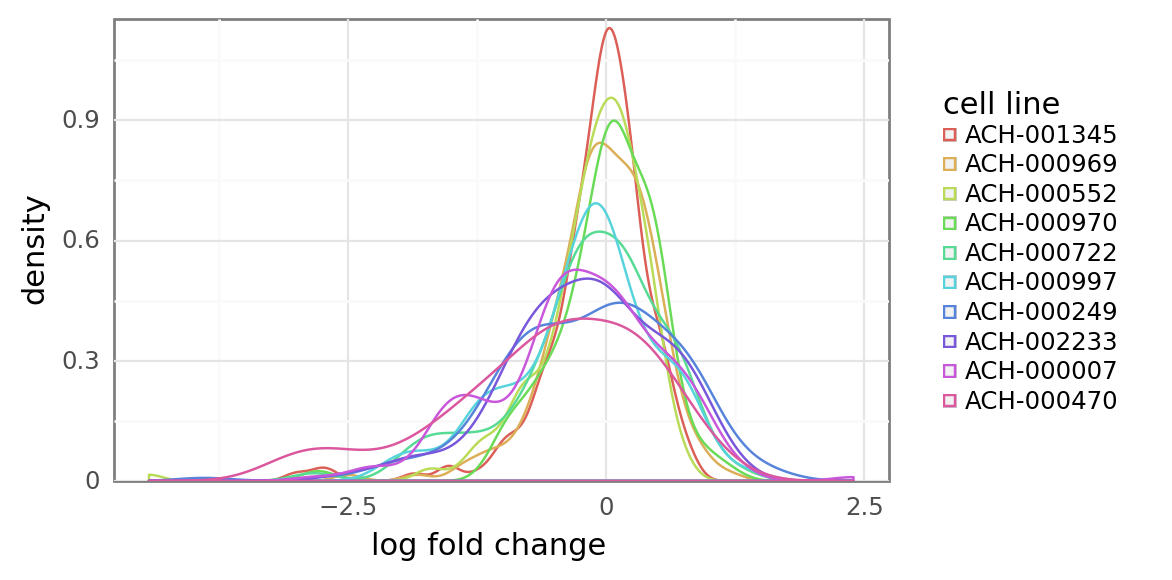

<ggplot: (371608986)>

In [25]:
cell_line_sd_order = (
    az.summary(sp7.mcmc_results, var_names=["σ_μ_a"], kind="stats")
    .assign(depmap_id=cell_lines)
    .sort_values("mean")
    .depmap_id.values
)
screen_data_reordered_depmap_id = screen_data.copy().assign(
    depmap_id=lambda d: pd.Categorical(
        d.depmap_id.values, categories=cell_line_sd_order, ordered=True
    )
)

(
    gg.ggplot(screen_data_reordered_depmap_id, gg.aes(x="lfc", color="depmap_id"))
    + gg.geom_density(size=0.5, alpha=0)
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_hue()
    + gg.theme(legend_key_size=5, figure_size=(5, 3))
    + gg.labs(x="log fold change", y="density", color="cell line")
)

Similarly, we can also look at the varbility of the different sgRNAs.
Below is a plot of the data points for the 10 least and most variable sgRNAs, as measured by the model (parameter $\sigma_a$).

In [26]:
sp7_posterior_sigma_a = az.summary(
    sp7.mcmc_results, var_names=["σ_a"], hdi_prob=PYMC3.HDI_PROB
).assign(sgrna=sgrnas)

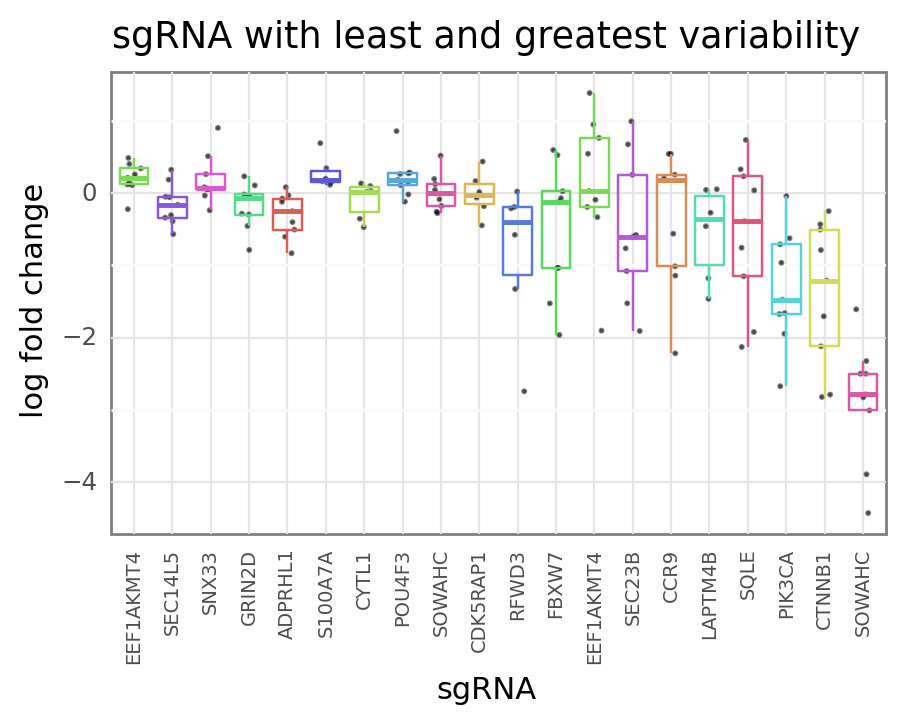

<ggplot: (372463821)>

In [27]:
sp7_posterior_sigma_a_tops = pd.concat(
    [
        sp7_posterior_sigma_a.sort_values("mean").head(10),
        sp7_posterior_sigma_a.sort_values("mean").tail(10),
    ]
)

screen_data_sgrna_var = screen_data[
    screen_data.sgrna.isin(sp7_posterior_sigma_a_tops.sgrna)
].assign(
    sgrna=lambda d: pd.Categorical(
        d.sgrna, categories=sp7_posterior_sigma_a_tops.sgrna, ordered=True
    )
)
screen_data_sgrna_var["hugo_symbol"] = screen_data_sgrna_var.hugo_symbol.astype("str")


def get_hugo_symbol_for_sgrna(sgrna_dict: dict[str, int]) -> list[str]:
    gene_list: list[str] = []
    for sgrna, idx in sgrna_dict.items():
        g = screen_data_sgrna_var.query(f"sgrna == '{sgrna}'").hugo_symbol.unique()[0]
        gene_list.append(g)
    return gene_list


(
    gg.ggplot(screen_data_sgrna_var, gg.aes(x="sgrna", y="lfc"))
    + gg.geom_jitter(width=0.2, height=0, size=0.2, alpha=0.5)
    + gg.geom_boxplot(gg.aes(color="hugo_symbol"), outlier_alpha=0, alpha=0)
    + gg.scale_x_discrete(labels=get_hugo_symbol_for_sgrna)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=7),
        figure_size=(5, 3),
        legend_position="none",
    )
    + gg.labs(
        x="sgRNA",
        y="log fold change",
        title="sgRNA with least and greatest variability",
    )
)

In the plot above, gene *EEF1AKMT4* has one sgRNA in the 10 least variable guides and one in the 10 most variable guides.
In this smaller test data set, there were 3 sgRNAs for this gene.
Their measured LFC values are show below (color) for each cell line (arranged along the x-axis).

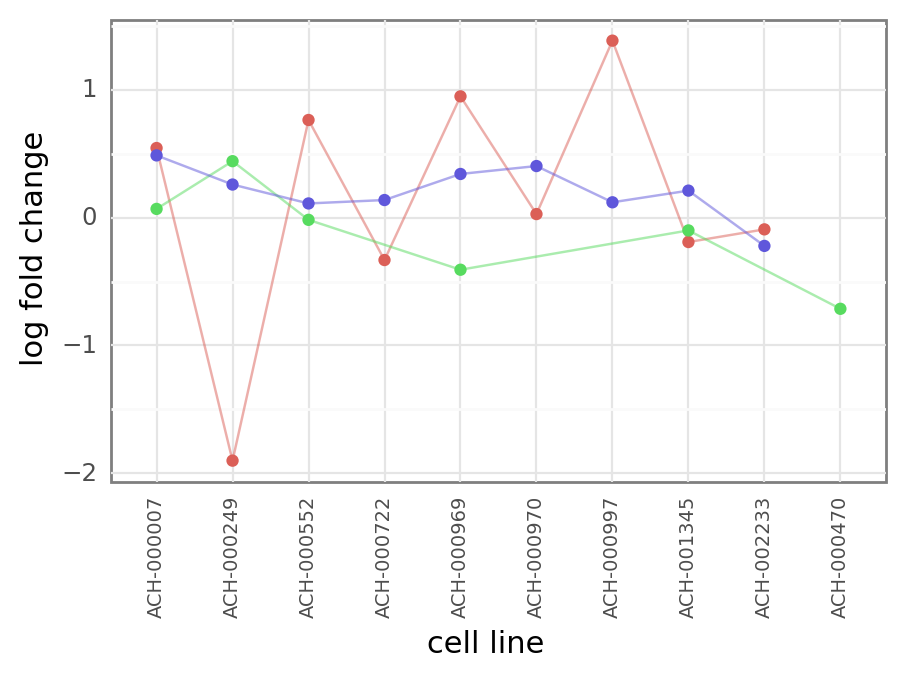

<ggplot: (372124534)>

In [28]:
eef1akmt4_data = screen_data.copy().query("hugo_symbol == 'EEF1AKMT4'")
eef1akmt4_data["sgrna"] = eef1akmt4_data.sgrna.astype("str")

(
    gg.ggplot(eef1akmt4_data, gg.aes(x="depmap_id", y="lfc"))
    + gg.geom_line(gg.aes(color="sgrna", group="sgrna"), alpha=0.5)
    + gg.geom_point(gg.aes(color="sgrna"))
    + gg.theme(
        axis_text_x=gg.element_text(size=7, angle=90),
        legend_position="none",
        figure_size=(5, 3),
    )
    + gg.labs(x="cell line", y="log fold change")
)

Hopefully, we will be able to use ADVI to fit models, too, because it is faster and is less computationally expensive.
Below shows the history of the ELBO during the fitting process.
Ideally, the curve should level off shortly before termination, but we can see that it did not.

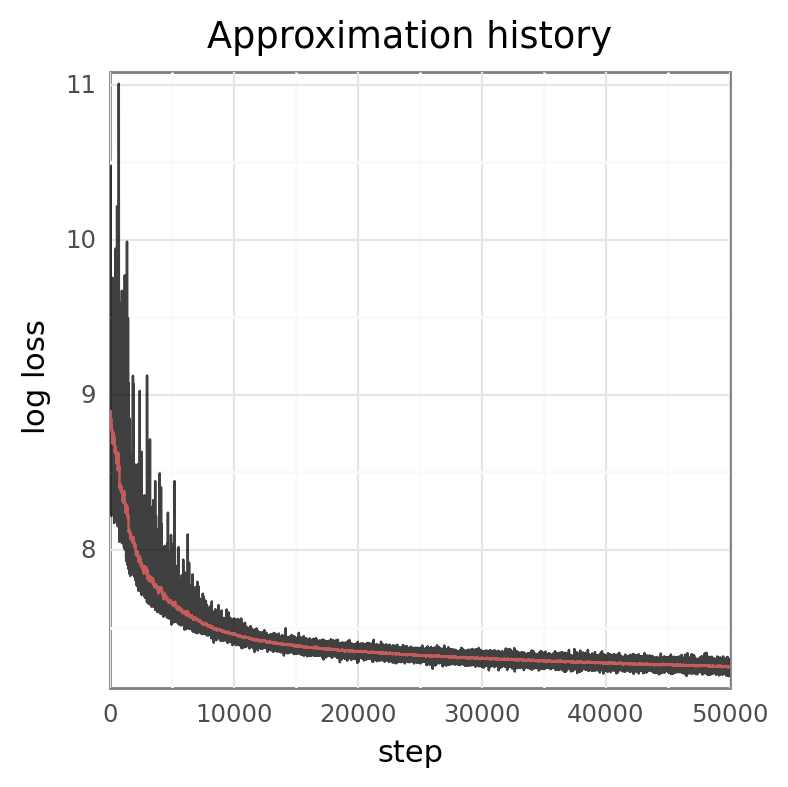

<ggplot: (372626426)>

In [29]:
pmanal.plot_vi_hist(sp7.advi_results[1], y_log=True)

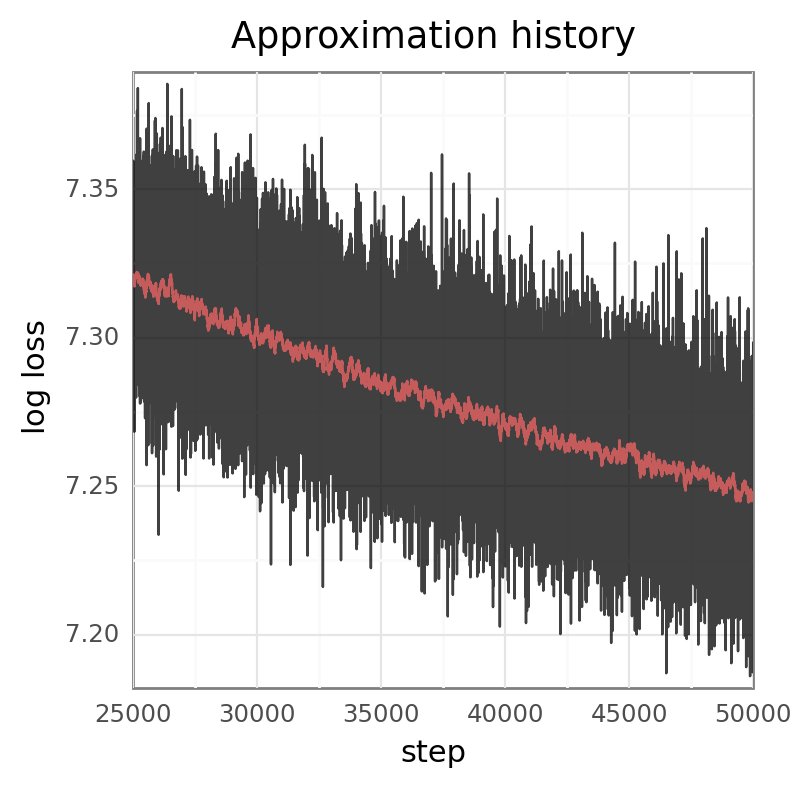

<ggplot: (372137298)>

In [30]:
pmanal.plot_vi_hist(sp7.advi_results[1], y_log=True, x_start=0.5)

Importantly, even though ADVI did not converge, the variance of the $\mu_a$ hyperprior is muted.
This is usually a result of "overfitting" with ADVI (continuing the process after the ELBO levels off), but this shows that the effect is stronger for higher-level parameters.
I will try using the full-rank ADVI algorithm instead of the mean-field approximation to see if that helps maintain variance.

In [31]:
sp7_advi_posterior_mu_a = (
    az.summary(sp7.advi_results[0], var_names=["μ_a"], hdi_prob=PYMC3.HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "parameter"})
    .pipe(
        pmanal.extract_matrix_variable_indices,
        col="parameter",
        idx1=np.array(genes),
        idx2=np.array(cell_lines),
        idx1name="hugo_symbol",
        idx2name="depmap_id",
    )
)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [32]:
sp7_combined_posterior_mu_a = pd.concat(
    [sp7_posterior_mu_a.assign(fit="MCMC"), sp7_advi_posterior_mu_a.assign(fit="ADVI")]
)

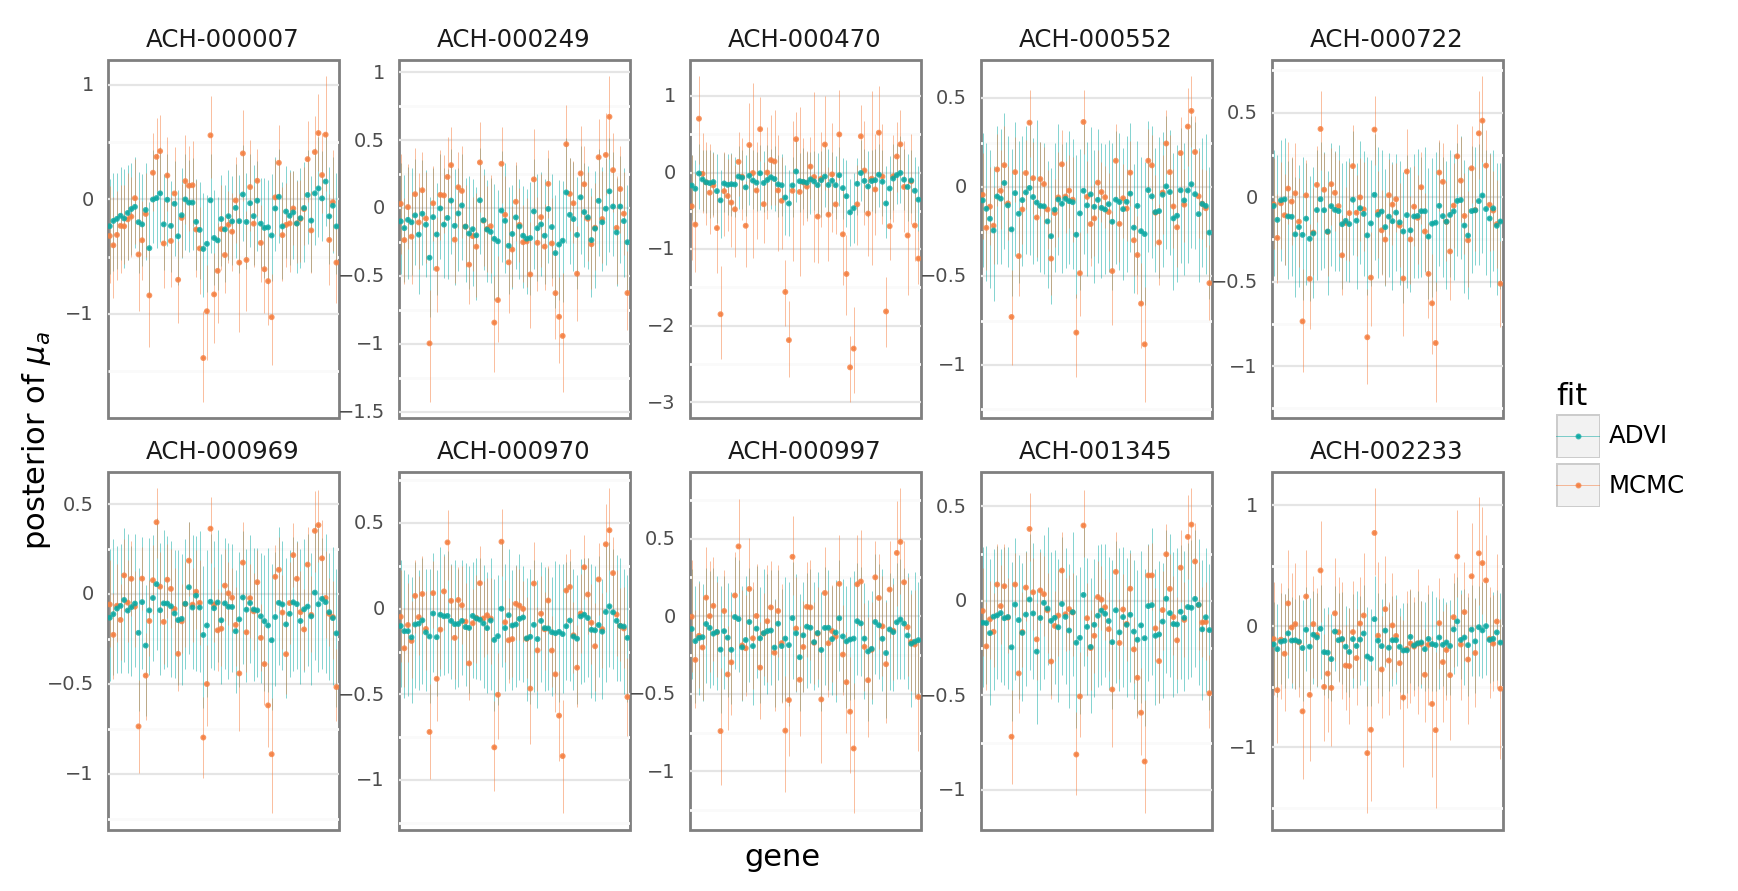

<ggplot: (372742391)>

In [33]:
fit_pal = {"MCMC": FitMethodColors.PYMC3_MCMC, "ADVI": FitMethodColors.PYMC3_ADVI}
(
    gg.ggplot(
        sp7_combined_posterior_mu_a, gg.aes(x="hugo_symbol", y="mean", color="fit")
    )
    + gg.facet_wrap("~ depmap_id", nrow=2, scales="free_y")
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), size=0.2, alpha=0.5)
    + gg.geom_point(size=0.2, alpha=0.8)
    + gg.scale_color_manual(fit_pal)
    + gg.theme(
        axis_text_x=gg.element_blank(),
        panel_grid_major_x=gg.element_blank(),
        figure_size=(9, 5),
        panel_spacing_x=0.3,
        axis_text_y=gg.element_text(size=7),
    )
    + gg.labs(x="gene", y="posterior of $\\mu_a$")
)

---

In [34]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 3.44 minutes


In [35]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-11

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : Clang 11.0.1 
OS          : Darwin
Release     : 20.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: fit-models

sys       : 3.9.2 | packaged by conda-forge | (default, Feb 21 2021, 05:02:20) 
[Clang 11.0.1 ]
numpy     : 1.20.1
seaborn   : 0.11.1
theano    : 1.0.5
pandas    : 1.2.3
arviz     : 0.11.2
logging   : 0.5.1.2
plotnine  : 0.8.0
pymc3     : 3.11.1
matplotlib: 3.3.4
re        : 2.2.1

